In [1]:
import mplfinance as mpf
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
API_keys = open('API_KEYS.txt',"r").read().split()

In [3]:
def dataframe(ticker):
    # Loads in dataframe and renames columns
    API_key = API_keys[random.randint(0,8)]
    time = TimeSeries(key = API_key,output_format='pandas')
    data = time.get_intraday(symbol=ticker,interval='1min',outputsize='full')[0].rename(columns={"1. open":"Open","2. high":"High","3. low":"Low","4. close":"Close","5. volume":"Volume"})  
    
    # Splits dataframe into a list of dataframes of each day
    days = [group[1] for group in data.groupby(data.index.day)]
    return days 

In [4]:
# Calculates indicators and adds each indicator as a column in the dataframe
def initialize_indicators(dataframe):
    dataframe['VWAP'] = (((dataframe['High']+dataframe['Low']+dataframe['Close'])*dataframe['Volume']/3).cumsum())/dataframe['Volume'].cumsum()
    dataframe['percent'] = ((dataframe['Close'])-dataframe['VWAP'])/dataframe['VWAP']
    dataframe['TWAP'] = ((dataframe['Open'] + dataframe['High'] + dataframe['Low'] + dataframe['Close'])/4).expanding().mean()
    dataframe["EMA10"] = dataframe['Close'].ewm(span=10,adjust=False).mean()
    dataframe["EMA20"] = dataframe['Close'].ewm(span=20,adjust=False).mean()
    dataframe = dataframe.dropna()
    
    return dataframe

In [5]:
# Plots the indicators, price, and volume 
def graph(ticker, dataframe):
    vwap = mpf.make_addplot(dataframe['VWAP'])
    twap = mpf.make_addplot(dataframe['TWAP'])
    ema10 = mpf.make_addplot(dataframe['EMA10'])
    ema20 = mpf.make_addplot(dataframe['EMA20'])
    mpf.plot(dataframe,addplot=[vwap,twap,ema10,ema20],type='candle',style='yahoo',volume=True,title=f"{dataframe.index.date[0]} {ticker}")
    # fig, axes = mpf.plot(df,addplot=[vwap,twap,ema10,ema20],type='candle',style='yahoo',volume=True,title=f"{df.index.date[0]} {ticker}")
    # axes[0].legend(mav_titles)
    # fig.savefig(path_to_figure)

In [6]:
# Runs through stock data and calls strategies and graphs
def algorithims(ticker,cash,show_transactions,show_graphs):
    # Calls function to load in dataframe
    days = dataframe(ticker)
    
    # Initialize returns for strategies 
    strategy1_returns = np.empty(0)
    strategy2_returns = np.empty(0)
    strategy3_returns = np.empty(0)
    strategy4_returns = np.empty(0)
    market_returns = np.empty(0)
    
    # Loops through dataframes and performs strategies and graphs
    for df in days:
        # Limits data to only during trading hours
        df = df.loc[(df.index >= f'{df.index.date[0]} 9:30:00')]
        df = df.loc[(df.index <= f'{df.index.date[0]} 16:00:00')]   
        
        # Aggregates one minutes 
        df = df.resample('5T').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})  
        
        # Add calculated columns for desired indicators 
        df = initialize_indicators(df)

        # Plot indicators and price
        if show_graphs:
            graph(ticker, df)
        
        # Run strategies and add up returns using numpy arrays
        num_days = len(df)
        
        strategy1_returns = np.append(strategy1_returns,strategy1(df,ticker,cash/num_days,show_transactions))
        strategy2_returns = np.append(strategy2_returns,strategy2(df,ticker,cash/num_days,show_transactions))
        strategy3_returns = np.append(strategy3_returns,strategy3(df,ticker,cash/num_days,show_transactions))
        strategy4_returns = np.append(strategy4_returns,strategy4(df,ticker,cash/num_days,show_transactions))
        market_returns = np.append(market_returns,market(df,ticker,cash/num_days))
    returns = np.array([strategy1_returns,strategy2_returns,strategy3_returns,strategy4_returns,market_returns])
    return returns

In [7]:
# VWAP Cross:
# Long when price crosses above VWAP and short when VWAP goes below
def strategy1(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Cross strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] < row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Long position 
        if ((row['VWAP'] < row['Close']) and (row['VWAP'] < row['Close']) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
        # Short position
        if ((row['VWAP'] > row['Close']) and (row['VWAP'] > row['Close']) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [8]:
# VWAP Mean Reversion: 
# Long at troughs and short at peaks with assumption that price will return to VWAP
def strategy2(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Mean reversion with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    percent_from_mean = 0.01
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] > row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Long position 
        if ((row['percent'] < -(percent_from_mean)) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
        # Short position
        if ((row['percent'] > percent_from_mean) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [9]:
# EMA
def strategy3(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting EMA Cross strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    transactions = 0
    for index,row in df.iterrows():
        # if (not i): 
            # sets initial position based on inital VWAP and price
            # long = row['VWAP'] < row['Close'] 
            # short = not long
            # transactions += 1
            # i += 1
            # if long:
            #     shares = cash/row['Close']
            #     cash = 0
            #     if show_transactions:
            #         print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            # if short:
            #     shorts = cash/row['Close']
            #     cash = cash0*2
            #     if show_transactions:
            #         print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Buy position 
        if ( ( row['EMA10'] > row['EMA20'] ) and cash ):
            shares = cash/row['Close']
            cash = 0
            
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 1
        
        # Sell position
        if ( ( row['EMA10'] < row['EMA20'] ) and not cash):
            cash = shares*row['Close']
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share") 
            shares = 0
            transactions += 1
        price = row['Close']
    # Exit position and calculate returns
    if show_transactions:
        print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
    cash += shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [10]:
# TWAP + VWAP strategy
# Long when price is greater than VWAP and TWAP and VWAP > TWAP
# Short when price is less than VWAP and TWAP and VWAP < TWAP

def strategy4(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Cross strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] < row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
                    
        # Long position 
        if ((row['VWAP'] < row['Close']) and (row['VWAP'] < row['Close']) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
            
        # Short position
        if ((row['VWAP'] > row['Close']) and (row['VWAP'] > row['Close']) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
        
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [11]:
# Market Performance:
# Returns if you bought at open and sold at close
def market(df,ticker,cash):
    open_price = df['Open'].loc[f'{df.index.date[0]} 9:30:00']
    shares = cash/open_price
    close_price = df['Close'].loc[f'{df.index.date[0]} 16:00:00']
    return shares*close_price

In [12]:
# Prints returns for each strategy for one stock at a time
def print_stock_returns(ticker,returns,cash_per_stock):
    print(f'{ticker} Returns')
    for i in range(0,returns.shape[0]-1):
        print(f'Strategy {i+1}: {(np.sum(returns[i]) - cash_per_stock)*100/cash_per_stock:.3f}%')
    print(f'Market    : {(np.sum(returns[-1]) - cash_per_stock)*100/cash_per_stock:.3f}%')
    print('-'*50)

In [13]:
# Prints returns for each strategy overall
def print_summary_returns(all_returns,cash):
    strat1 = 0
    strat2 = 0
    strat3 = 0
    strat4 = 0
    market = 0
    for i in range(0,all_returns.shape[0]):
        if i % 5 == 0:
            strat1 += all_returns[i].sum()
        if i % 5 == 1:
            strat2 += all_returns[i].sum()
        if i % 5 == 2:
            strat3 += all_returns[i].sum()
        if i % 5 == 3:
            strat4 += all_returns[i].sum()
        if i % 5 == 4:
            market += all_returns[i].sum()
    print('Portfolio Returns')
    print(f'Strategy 1: {(strat1-cash)*100/cash:.3f}%')
    print(f'Strategy 2: {(strat2-cash)*100/cash:.3f}%')
    print(f'Strategy 3: {(strat3-cash)*100/cash:.3f}%')
    print(f'Strategy 4: {(strat4-cash)*100/cash:.3f}%')
    print(f'Market    : {(market-cash)*100/cash:.3f}%')

In [14]:
# Calls algorithims function and prints returns using print functions
def main(stocks,cash,show_transactions=False,show_graphs=False):
    # Initializes numpy arrays for 
    returns = np.empty((0,0))
    all_returns = np.empty((0,10))
    cash_per_stock = cash/len(stocks)
    for ticker in stocks:
        returns = algorithims(ticker,cash_per_stock,show_transactions,show_graphs)
        all_returns = np.append(all_returns,returns,axis=0)
        print_stock_returns(ticker,returns,cash_per_stock)
    print_summary_returns(all_returns,cash)

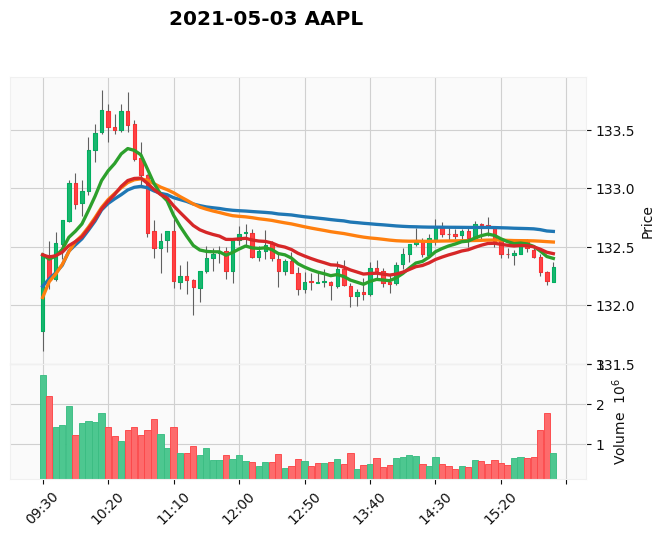

2021-05-03: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.912 AAPL shares at 132.4312 per share
10:50:00: Sell 1.912 AAPL shares at 132.6209 per share
10:50:00: Open 1.912 AAPL short contracts at 132.6209 per contract
14:30:00: Close 1.912 AAPL short contracts at 132.6708 per contract
14:30:00: Buy 1.910 AAPL shares at 132.6708 per share
14:35:00: Sell 1.910 AAPL shares at 132.6061 per share
14:35:00: Open 1.910 AAPL short contracts at 132.6061 per contract
15:00:00: Close 1.910 AAPL short contracts at 132.6908 per contract
15:00:00: Buy 1.908 AAPL shares at 132.6908 per share
15:15:00: Sell 1.908 AAPL shares at 132.5461 per share
15:15:00: Open 1.908 AAPL short contracts at 132.5461 per contract
16:00:00: Close 1.908 AAPL short contracts at 132.3264 per contract
Cash: 253.2895041705524
Return: 0.05%
Transactions: 12
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $253.16455696202533 USD
09

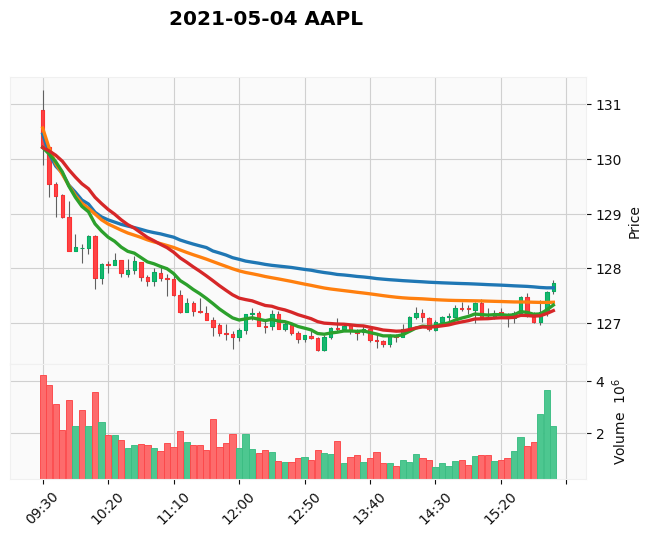

2021-05-04: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.944 AAPL short contracts at 130.21 per contract
16:00:00: Close 1.944 AAPL short contracts at 127.7242 per contract
16:00:00: Buy 2.020 AAPL shares at 127.7242 per share
16:00:00: Sell 2.020 AAPL shares at 127.7242 per share
Cash: 257.9976454782392
Return: 1.91%
Transactions: 4
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 1.944 AAPL shares at 130.21 per share
16:00:00: Sell 1.944 AAPL shares at 127.7242 per share
Cash: 248.33146844581148
Return: -1.91%
Transactions: 2
----------------------------------------------------------------------
2021-05-04: Starting EMA Cross strategy with $253.16455696202533 USD
14:20:00: Buy 1.992 AAPL shares at 127.1052 per share
16:00:00: Sell 1.992 AAPL shares at 127.7242 per share
Cash: 254.39746372555265
Return: 0.49%
Transactions: 2
--------------------------

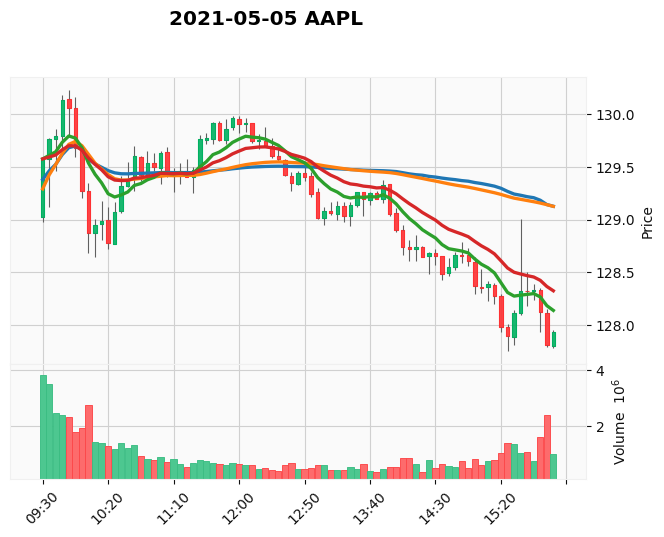

2021-05-05: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.954 AAPL shares at 129.5741 per share
09:55:00: Sell 1.954 AAPL shares at 129.6809 per share
09:55:00: Open 1.954 AAPL short contracts at 129.6809 per contract
10:40:00: Close 1.954 AAPL short contracts at 129.601 per contract
10:40:00: Buy 1.956 AAPL shares at 129.601 per share
10:45:00: Sell 1.956 AAPL shares at 129.4213 per share
10:45:00: Open 1.956 AAPL short contracts at 129.4213 per contract
10:50:00: Close 1.956 AAPL short contracts at 129.5361 per contract
10:50:00: Buy 1.953 AAPL shares at 129.5361 per share
11:05:00: Sell 1.953 AAPL shares at 129.4212 per share
11:05:00: Open 1.953 AAPL short contracts at 129.4212 per contract
11:15:00: Close 1.953 AAPL short contracts at 129.4613 per contract
11:15:00: Buy 1.952 AAPL shares at 129.4613 per share
11:20:00: Sell 1.952 AAPL shares at 129.4014 per share
11:20:00: Open 1.952 AAPL short contracts at 129.4014 per contract
11:25:00: Close 1.952 AA

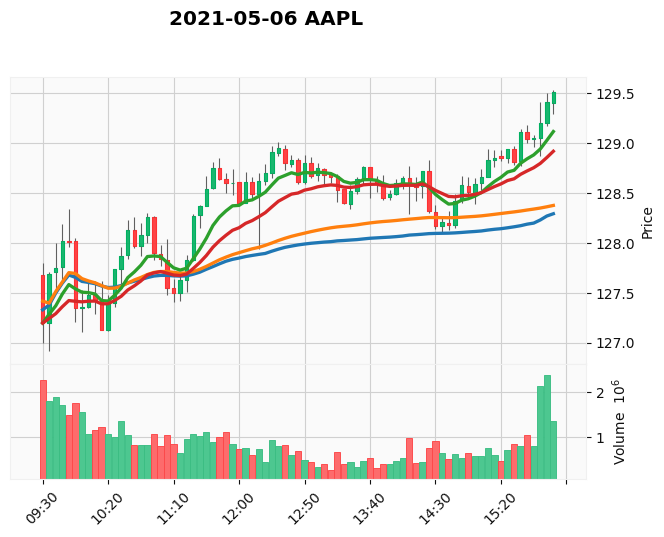

2021-05-06: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.990 AAPL short contracts at 127.1951 per contract
09:35:00: Close 1.990 AAPL short contracts at 127.6872 per contract
09:35:00: Buy 1.975 AAPL shares at 127.6872 per share
09:55:00: Sell 1.975 AAPL shares at 127.3448 per share
09:55:00: Open 1.975 AAPL short contracts at 127.3448 per contract
10:25:00: Close 1.975 AAPL short contracts at 127.734 per contract
10:25:00: Buy 1.963 AAPL shares at 127.734 per share
11:05:00: Sell 1.963 AAPL shares at 127.5445 per share
11:05:00: Open 1.963 AAPL short contracts at 127.5445 per contract
11:20:00: Close 1.963 AAPL short contracts at 127.8291 per contract
11:20:00: Buy 1.954 AAPL shares at 127.8291 per share
16:00:00: Sell 1.954 AAPL shares at 129.5112 per share
Cash: 253.09675757146454
Return: -0.03%
Transactions: 12
----------------------------------------------------------------------
2021-05-06: Starting VWAP Mean reversion with $253.16455696202533 USD
09

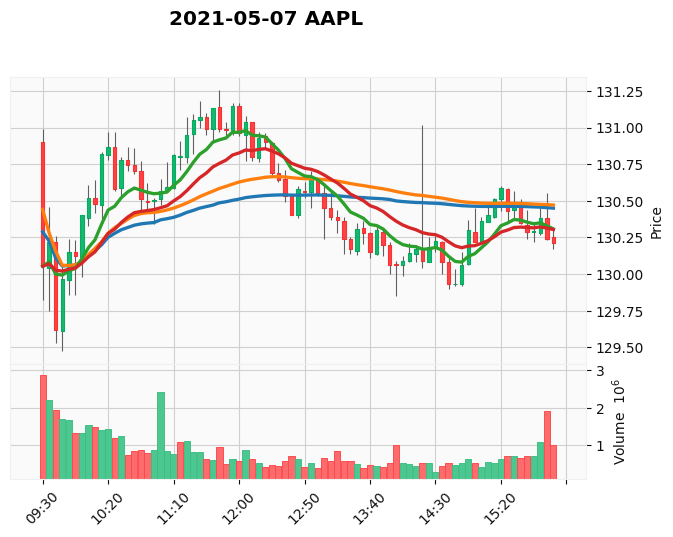

2021-05-07: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.947 AAPL short contracts at 130.0535 per contract
09:50:00: Close 1.947 AAPL short contracts at 130.1499 per contract
09:50:00: Buy 1.944 AAPL shares at 130.1499 per share
12:35:00: Sell 1.944 AAPL shares at 130.535 per share
12:35:00: Open 1.944 AAPL short contracts at 130.535 per contract
12:45:00: Close 1.944 AAPL short contracts at 130.58 per contract
12:45:00: Buy 1.942 AAPL shares at 130.58 per share
13:05:00: Sell 1.942 AAPL shares at 130.45 per share
13:05:00: Open 1.942 AAPL short contracts at 130.45 per contract
15:15:00: Close 1.942 AAPL short contracts at 130.51 per contract
15:15:00: Buy 1.941 AAPL shares at 130.51 per share
15:25:00: Sell 1.941 AAPL shares at 130.4311 per share
15:25:00: Open 1.941 AAPL short contracts at 130.4311 per contract
15:30:00: Close 1.941 AAPL short contracts at 130.48 per contract
15:30:00: Buy 1.939 AAPL shares at 130.48 per share
15:35:00: Sell 1.939 AAPL s

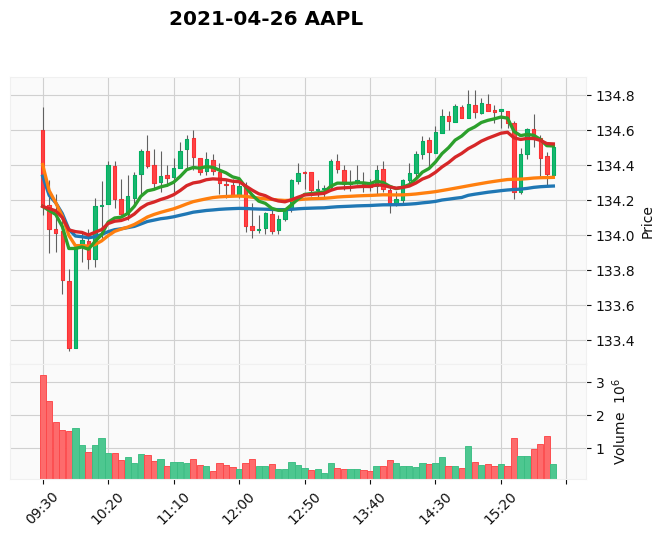

2021-04-26: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.887 AAPL short contracts at 134.1633 per contract
10:10:00: Close 1.887 AAPL short contracts at 134.1633 per contract
10:10:00: Buy 1.887 AAPL shares at 134.1633 per share
12:05:00: Sell 1.887 AAPL shares at 134.0535 per share
12:05:00: Open 1.887 AAPL short contracts at 134.0535 per contract
12:40:00: Close 1.887 AAPL short contracts at 134.3131 per contract
12:40:00: Buy 1.880 AAPL shares at 134.3131 per share
15:30:00: Sell 1.880 AAPL shares at 134.2482 per share
15:30:00: Open 1.880 AAPL short contracts at 134.2482 per contract
15:35:00: Close 1.880 AAPL short contracts at 134.4628 per contract
15:35:00: Buy 1.874 AAPL shares at 134.4628 per share
16:00:00: Sell 1.874 AAPL shares at 134.5027 per share
Cash: 252.01688950544875
Return: -0.45%
Transactions: 12
----------------------------------------------------------------------
2021-04-26: Starting VWAP Mean reversion with $253.16455696202533 USD


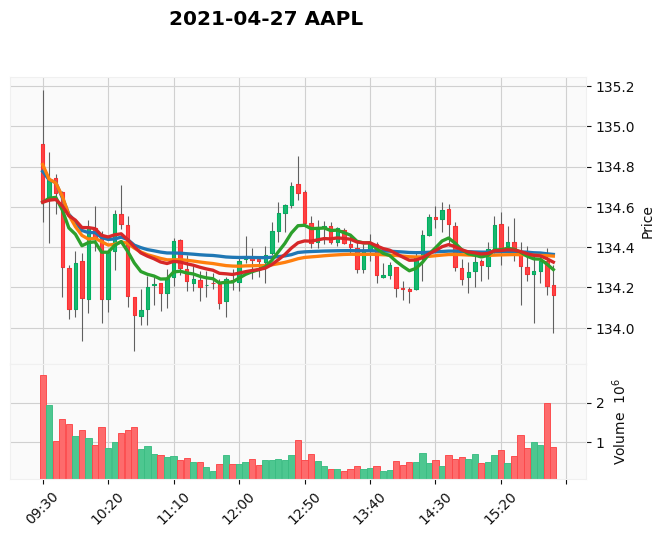

2021-04-27: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.881 AAPL short contracts at 134.6225 per contract
10:05:00: Close 1.881 AAPL short contracts at 134.4929 per contract
10:05:00: Buy 1.884 AAPL shares at 134.4929 per share
10:10:00: Sell 1.884 AAPL shares at 134.4427 per share
10:10:00: Open 1.884 AAPL short contracts at 134.4427 per contract
10:25:00: Close 1.884 AAPL short contracts at 134.5626 per contract
10:25:00: Buy 1.881 AAPL shares at 134.5626 per share
10:35:00: Sell 1.881 AAPL shares at 134.1554 per share
10:35:00: Open 1.881 AAPL short contracts at 134.1554 per contract
11:10:00: Close 1.881 AAPL short contracts at 134.4299 per contract
11:10:00: Buy 1.873 AAPL shares at 134.4299 per share
11:15:00: Sell 1.873 AAPL shares at 134.2981 per share
11:15:00: Open 1.873 AAPL short contracts at 134.2981 per contract
12:20:00: Close 1.873 AAPL short contracts at 134.363 per contract
12:20:00: Buy 1.871 AAPL shares at 134.363 per share
13:30:00: S

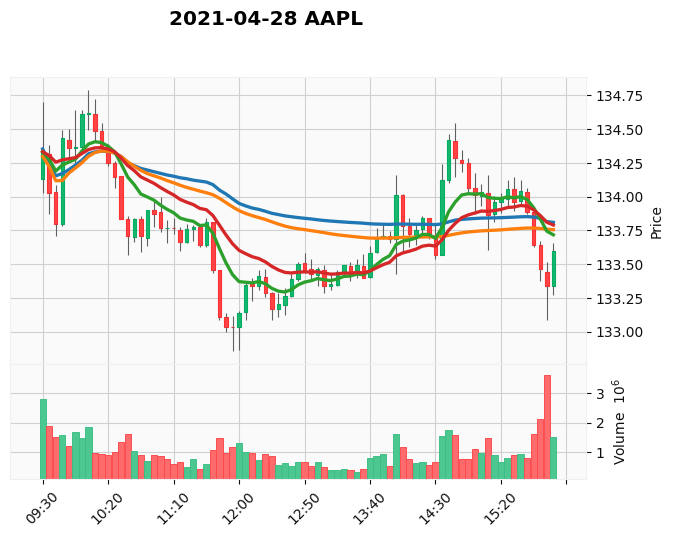

2021-04-28: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.885 AAPL short contracts at 134.333 per contract
09:45:00: Close 1.885 AAPL short contracts at 134.4329 per contract
09:45:00: Buy 1.882 AAPL shares at 134.4329 per share
10:20:00: Sell 1.882 AAPL shares at 134.2514 per share
10:20:00: Open 1.882 AAPL short contracts at 134.2514 per contract
14:00:00: Close 1.882 AAPL short contracts at 134.0136 per contract
14:00:00: Buy 1.888 AAPL shares at 134.0136 per share
14:05:00: Sell 1.888 AAPL shares at 133.784 per share
14:05:00: Open 1.888 AAPL short contracts at 133.784 per contract
14:20:00: Close 1.888 AAPL short contracts at 133.8439 per contract
14:20:00: Buy 1.887 AAPL shares at 133.8439 per share
14:25:00: Sell 1.887 AAPL shares at 133.7116 per share
14:25:00: Open 1.887 AAPL short contracts at 133.7116 per contract
14:35:00: Close 1.887 AAPL short contracts at 134.1234 per contract
14:35:00: Buy 1.875 AAPL shares at 134.1234 per share
15:45:00: Se

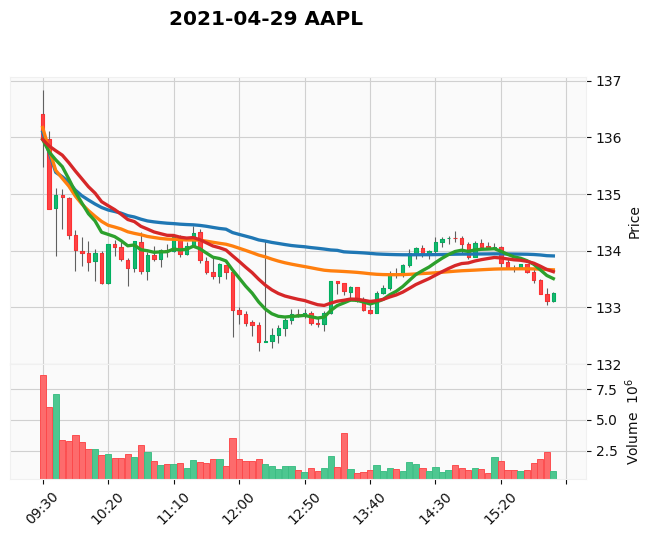

2021-04-29: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.862 AAPL short contracts at 135.9603 per contract
14:10:00: Close 1.862 AAPL short contracts at 133.9537 per contract
14:10:00: Buy 1.918 AAPL shares at 133.9537 per share
14:55:00: Sell 1.918 AAPL shares at 133.8849 per share
14:55:00: Open 1.918 AAPL short contracts at 133.8849 per contract
15:00:00: Close 1.918 AAPL short contracts at 134.1335 per contract
15:00:00: Buy 1.911 AAPL shares at 134.1335 per share
15:20:00: Sell 1.911 AAPL shares at 133.784 per share
15:20:00: Open 1.911 AAPL short contracts at 133.784 per contract
16:00:00: Close 1.911 AAPL short contracts at 133.2549 per contract
Cash: 256.63538750258533
Return: 1.37%
Transactions: 10
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 1.862 AAPL shares at 135.9603 per share
16:00:00: Sell 1.862 AAPL shares at 133.2549 per share
Cas

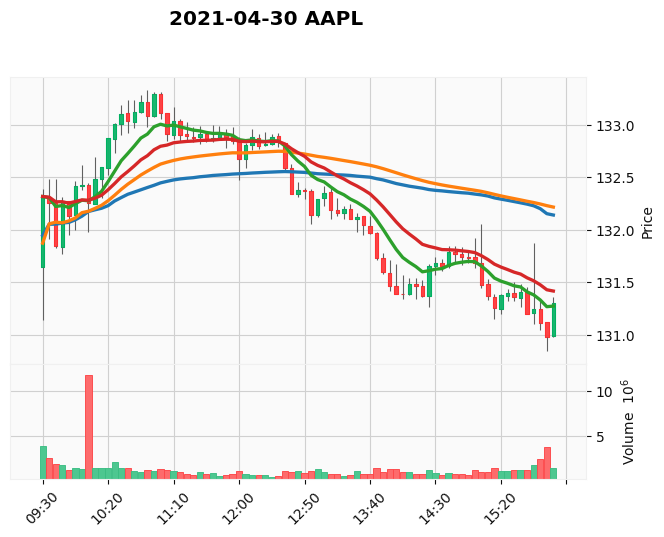

2021-04-30: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.913 AAPL shares at 132.3164 per share
09:40:00: Sell 1.913 AAPL shares at 131.8471 per share
09:40:00: Open 1.913 AAPL short contracts at 131.8471 per contract
09:45:00: Close 1.913 AAPL short contracts at 132.2715 per contract
09:45:00: Buy 1.901 AAPL shares at 132.2715 per share
12:40:00: Sell 1.901 AAPL shares at 132.3414 per share
12:40:00: Open 1.901 AAPL short contracts at 132.3414 per contract
16:00:00: Close 1.901 AAPL short contracts at 131.2982 per contract
Cash: 253.5706742692971
Return: 0.16%
Transactions: 8
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 1.913 AAPL short contracts at 132.3164 per contract
16:00:00: Close 1.913 AAPL short contracts at 131.2982 per contract
Cash: 255.11270663885094
Return: 0.77%
Transactions: 2
---------------------------------------------------------

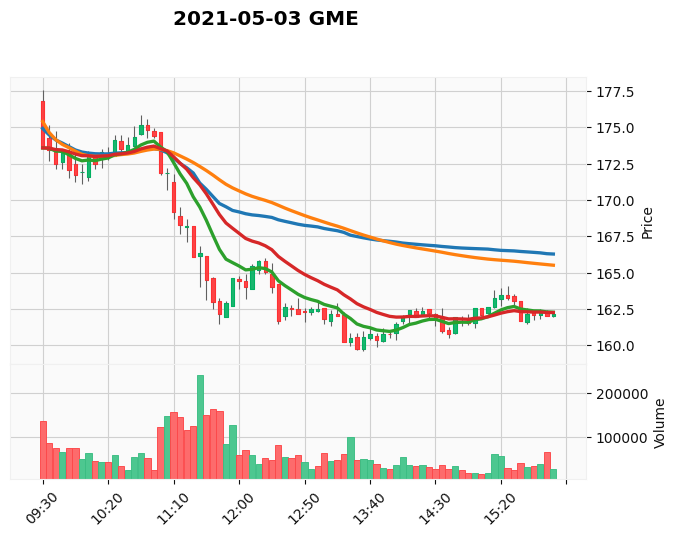

2021-05-03: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.458 GME short contracts at 173.59 per contract
10:15:00: Close 1.458 GME short contracts at 173.3 per contract
10:15:00: Buy 1.463 GME shares at 173.3 per share
11:00:00: Sell 1.463 GME shares at 171.85 per share
11:00:00: Open 1.463 GME short contracts at 171.85 per contract
16:00:00: Close 1.463 GME short contracts at 162.19 per contract
Cash: 265.60107398001725
Return: 4.91%
Transactions: 6
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 1.458 GME shares at 173.59 per share
16:00:00: Sell 1.458 GME shares at 162.19 per share
Cash: 236.53873779406007
Return: -6.57%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $253.16455696202533 USD
10:30:00: Buy 1.459 GME shares at 173.4999 per share
11:05:00: Sell 1.459 GM

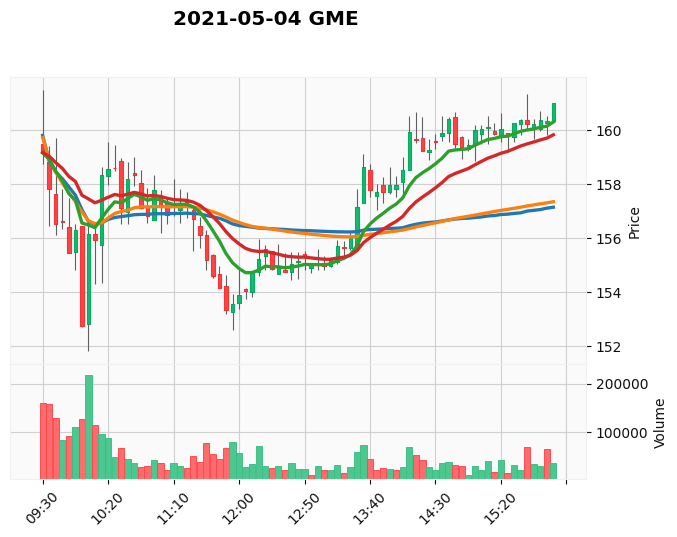

2021-05-04: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.591 GME short contracts at 159.1528 per contract
10:15:00: Close 1.591 GME short contracts at 158.3087 per contract
10:15:00: Buy 1.608 GME shares at 158.3087 per share
10:50:00: Sell 1.608 GME shares at 156.7911 per share
10:50:00: Open 1.608 GME short contracts at 156.7911 per contract
10:55:00: Close 1.608 GME short contracts at 157.78 per contract
10:55:00: Buy 1.588 GME shares at 157.78 per share
11:05:00: Sell 1.588 GME shares at 156.8443 per share
11:05:00: Open 1.588 GME short contracts at 156.8443 per contract
11:10:00: Close 1.588 GME short contracts at 156.9206 per contract
11:10:00: Buy 1.586 GME shares at 156.9206 per share
11:25:00: Sell 1.586 GME shares at 156.7057 per share
11:25:00: Open 1.586 GME short contracts at 156.7057 per contract
13:30:00: Close 1.586 GME short contracts at 157.14 per contract
13:30:00: Buy 1.577 GME shares at 157.14 per share
16:00:00: Sell 1.577 GME shares 

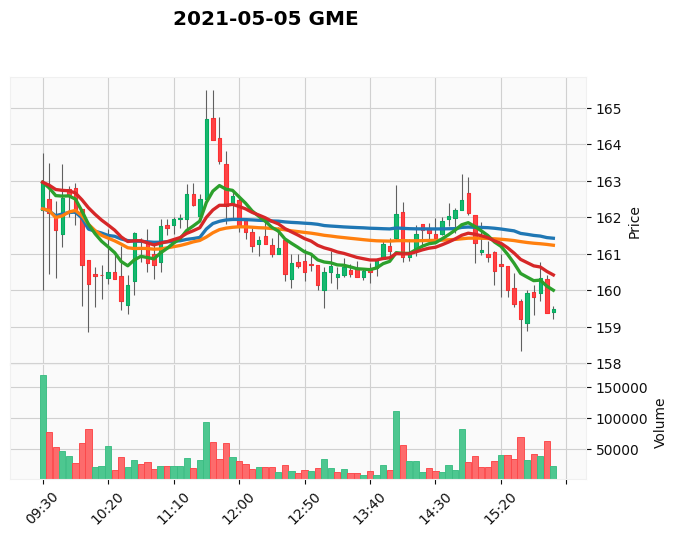

2021-05-05: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.554 GME shares at 162.96 per share
09:35:00: Sell 1.554 GME shares at 162.11 per share
09:35:00: Open 1.554 GME short contracts at 162.11 per contract
09:45:00: Close 1.554 GME short contracts at 162.52 per contract
09:45:00: Buy 1.546 GME shares at 162.52 per share
09:55:00: Sell 1.546 GME shares at 162.11 per share
09:55:00: Open 1.546 GME short contracts at 162.11 per contract
10:40:00: Close 1.546 GME short contracts at 161.5549 per contract
10:40:00: Buy 1.556 GME shares at 161.5549 per share
10:50:00: Sell 1.556 GME shares at 160.75 per share
10:50:00: Open 1.556 GME short contracts at 160.75 per contract
11:00:00: Close 1.556 GME short contracts at 161.7481 per contract
11:00:00: Buy 1.537 GME shares at 161.7481 per share
12:00:00: Sell 1.537 GME shares at 161.7588 per share
12:00:00: Open 1.537 GME short contracts at 161.7588 per contract
14:00:00: Close 1.537 GME short contracts at 162.1 per 

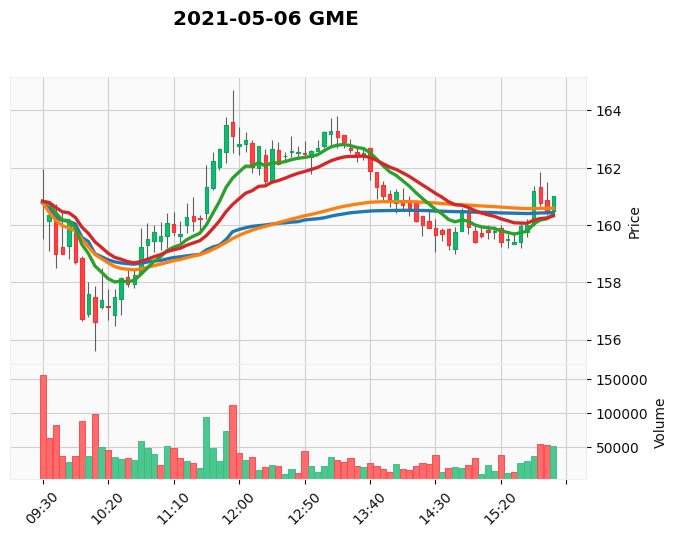

2021-05-06: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.574 GME shares at 160.827 per share
09:35:00: Sell 1.574 GME shares at 160.35 per share
09:35:00: Open 1.574 GME short contracts at 160.35 per contract
10:45:00: Close 1.574 GME short contracts at 159.23 per contract
10:45:00: Buy 1.596 GME shares at 159.23 per share
14:15:00: Sell 1.596 GME shares at 160.12 per share
14:15:00: Open 1.596 GME short contracts at 160.12 per contract
14:50:00: Close 1.596 GME short contracts at 160.48 per contract
14:50:00: Buy 1.589 GME shares at 160.48 per share
14:55:00: Sell 1.589 GME shares at 159.93 per share
14:55:00: Open 1.589 GME short contracts at 159.93 per contract
15:45:00: Close 1.589 GME short contracts at 161.2 per contract
15:45:00: Buy 1.564 GME shares at 161.2 per share
15:55:00: Sell 1.564 GME shares at 160.42 per share
15:55:00: Open 1.564 GME short contracts at 160.42 per contract
16:00:00: Close 1.564 GME short contracts at 161.01 per contract
16:

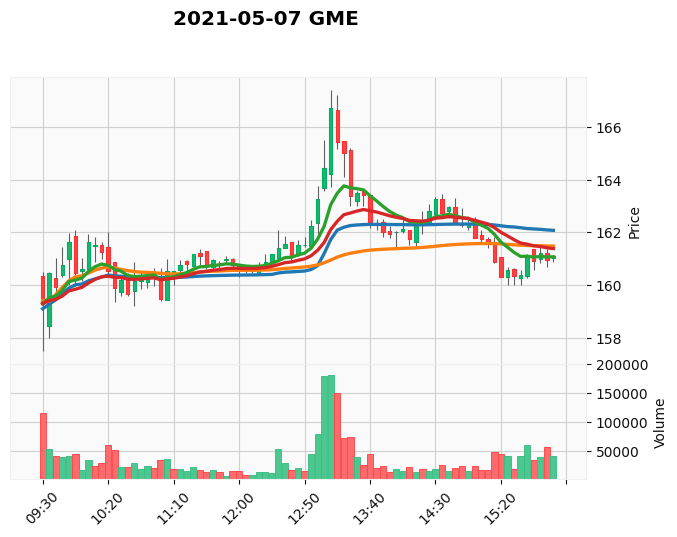

2021-05-07: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.589 GME shares at 159.3 per share
10:25:00: Sell 1.589 GME shares at 159.9 per share
10:25:00: Open 1.589 GME short contracts at 159.9 per contract
10:45:00: Close 1.589 GME short contracts at 160.3821 per contract
10:45:00: Buy 1.580 GME shares at 160.3821 per share
11:00:00: Sell 1.580 GME shares at 159.49 per share
11:00:00: Open 1.580 GME short contracts at 159.49 per contract
11:05:00: Close 1.580 GME short contracts at 160.52 per contract
11:05:00: Buy 1.559 GME shares at 160.52 per share
13:50:00: Sell 1.559 GME shares at 162.03 per share
13:50:00: Open 1.559 GME short contracts at 162.03 per contract
14:15:00: Close 1.559 GME short contracts at 162.29 per contract
14:15:00: Buy 1.554 GME shares at 162.29 per share
14:20:00: Sell 1.554 GME shares at 162.28 per share
14:20:00: Open 1.554 GME short contracts at 162.28 per contract
14:25:00: Close 1.554 GME short contracts at 162.825 per contract


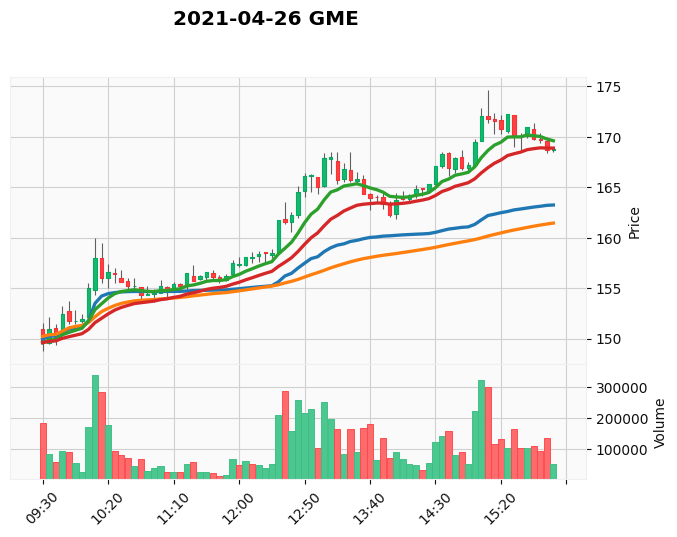

2021-04-26: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.692 GME short contracts at 149.585 per contract
09:35:00: Close 1.692 GME short contracts at 150.98 per contract
09:35:00: Buy 1.661 GME shares at 150.98 per share
09:40:00: Sell 1.661 GME shares at 150.2 per share
09:40:00: Open 1.661 GME short contracts at 150.2 per contract
09:45:00: Close 1.661 GME short contracts at 152.4321 per contract
09:45:00: Buy 1.613 GME shares at 152.4321 per share
10:45:00: Sell 1.613 GME shares at 154.35 per share
10:45:00: Open 1.613 GME short contracts at 154.35 per contract
11:00:00: Close 1.613 GME short contracts at 155.2246 per contract
11:00:00: Buy 1.594 GME shares at 155.2246 per share
16:00:00: Sell 1.594 GME shares at 168.8 per share
Cash: 269.1262623368634
Return: 6.30%
Transactions: 12
----------------------------------------------------------------------
2021-04-26: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 1.692 GME shares a

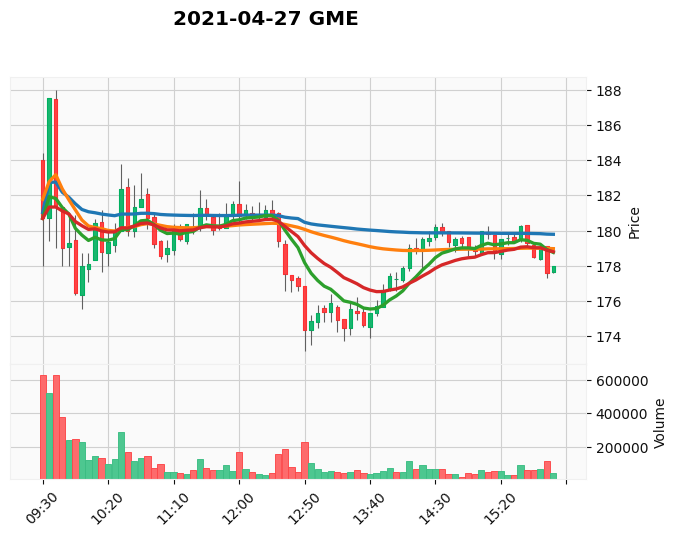

2021-04-27: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.401 GME short contracts at 180.6898 per contract
09:35:00: Close 1.401 GME short contracts at 187.5 per contract
09:35:00: Buy 1.299 GME shares at 187.5 per share
09:40:00: Sell 1.299 GME shares at 181.37 per share
09:40:00: Open 1.299 GME short contracts at 181.37 per contract
10:30:00: Close 1.299 GME short contracts at 182.39 per contract
10:30:00: Buy 1.285 GME shares at 182.39 per share
10:35:00: Sell 1.285 GME shares at 180.0 per share
10:35:00: Open 1.285 GME short contracts at 180.0 per contract
10:40:00: Close 1.285 GME short contracts at 181.3209 per contract
10:40:00: Buy 1.266 GME shares at 181.3209 per share
10:50:00: Sell 1.266 GME shares at 180.72 per share
10:50:00: Open 1.266 GME short contracts at 180.72 per contract
11:30:00: Close 1.266 GME short contracts at 181.3 per contract
11:30:00: Buy 1.258 GME shares at 181.3 per share
11:40:00: Sell 1.258 GME shares at 180.0211 per share


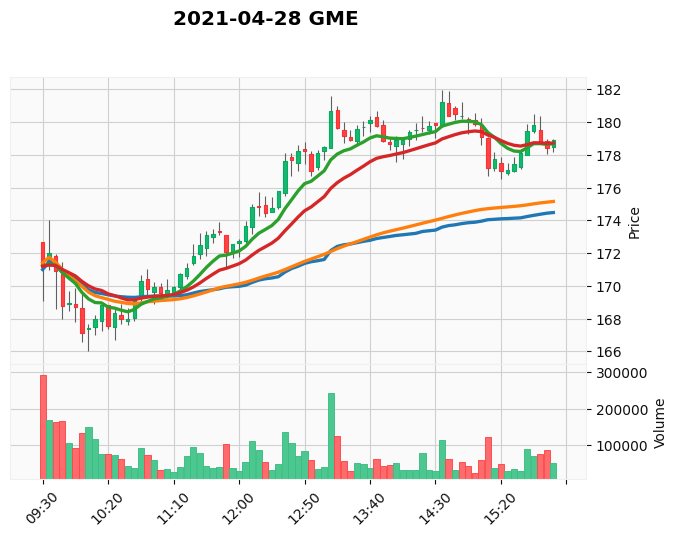

2021-04-28: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.479 GME shares at 171.2 per share
09:40:00: Sell 1.479 GME shares at 170.9035 per share
09:40:00: Open 1.479 GME short contracts at 170.9035 per contract
10:45:00: Close 1.479 GME short contracts at 170.2763 per contract
10:45:00: Buy 1.490 GME shares at 170.2763 per share
16:00:00: Sell 1.490 GME shares at 178.91 per share
Cash: 266.5148514947947
Return: 5.27%
Transactions: 6
----------------------------------------------------------------------
2021-04-28: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 1.479 GME short contracts at 171.2 per contract
09:45:00: Close 1.479 GME short contracts at 168.8 per contract
09:45:00: Buy 1.521 GME shares at 168.8 per share
11:25:00: Sell 1.521 GME shares at 171.81 per share
11:25:00: Open 1.521 GME short contracts at 171.81 per contract
16:00:00: Close 1.521 GME short contracts at 178.91 per contract
Cash: 250.49345895312973
Return: -1

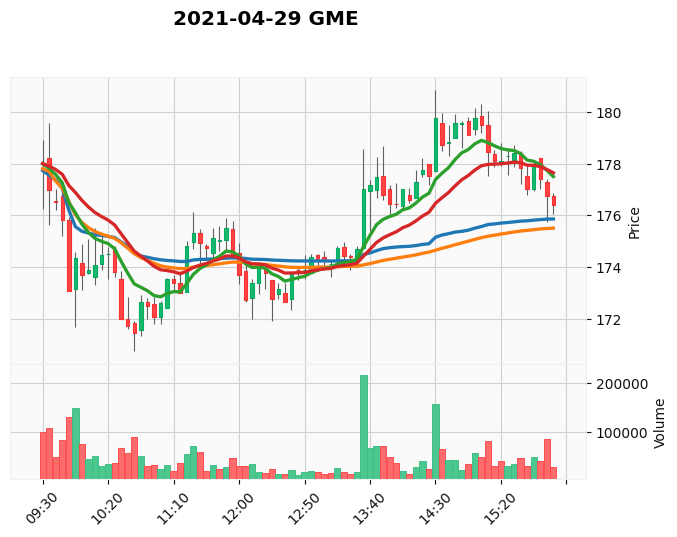

2021-04-29: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.422 GME shares at 178.0 per share
09:35:00: Sell 1.422 GME shares at 176.97 per share
09:35:00: Open 1.422 GME short contracts at 176.97 per contract
11:20:00: Close 1.422 GME short contracts at 174.8 per contract
11:20:00: Buy 1.458 GME shares at 174.8 per share
12:00:00: Sell 1.458 GME shares at 173.7 per share
12:00:00: Open 1.458 GME short contracts at 173.7 per contract
12:55:00: Close 1.458 GME short contracts at 174.4 per contract
12:55:00: Buy 1.446 GME shares at 174.4 per share
13:10:00: Sell 1.446 GME shares at 174.133 per share
13:10:00: Open 1.446 GME short contracts at 174.133 per contract
13:15:00: Close 1.446 GME short contracts at 174.75 per contract
13:15:00: Buy 1.436 GME shares at 174.75 per share
16:00:00: Sell 1.436 GME shares at 176.41 per share
Cash: 253.26735172598833
Return: 0.04%
Transactions: 14
----------------------------------------------------------------------
2021-04-2

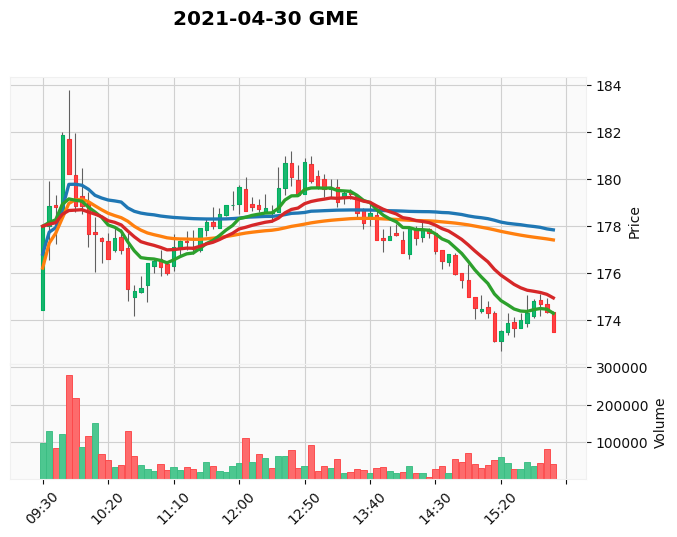

2021-04-30: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.422 GME shares at 178.0 per share
09:55:00: Sell 1.422 GME shares at 178.85 per share
09:55:00: Open 1.422 GME short contracts at 178.85 per contract
11:45:00: Close 1.422 GME short contracts at 178.535 per contract
11:45:00: Buy 1.427 GME shares at 178.535 per share
13:30:00: Sell 1.427 GME shares at 178.58 per share
13:30:00: Open 1.427 GME short contracts at 178.58 per contract
16:00:00: Close 1.427 GME short contracts at 173.51 per contract
Cash: 262.12210126877835
Return: 3.54%
Transactions: 8
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 1.422 GME short contracts at 178.0 per contract
10:05:00: Close 1.422 GME short contracts at 177.6655 per contract
10:05:00: Buy 1.428 GME shares at 177.6655 per share
12:35:00: Sell 1.428 GME shares at 180.6999 per share
12:35:00: Open 1.428 GME short c

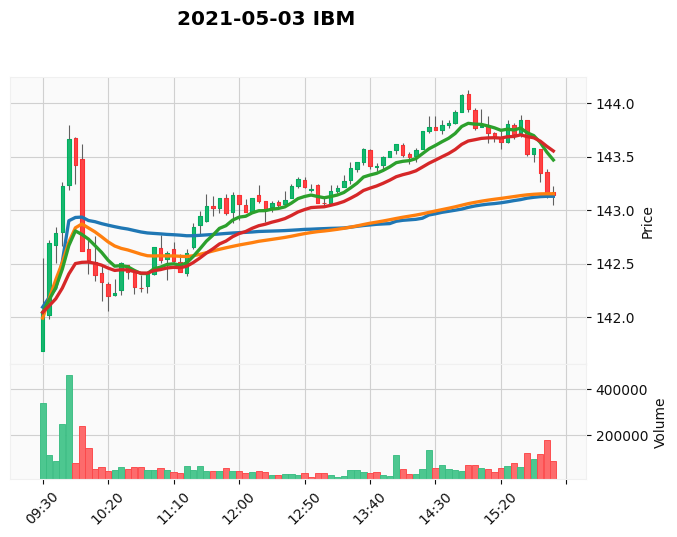

2021-05-03: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.782 IBM short contracts at 142.0441 per contract
09:35:00: Close 1.782 IBM short contracts at 142.6912 per contract
09:35:00: Buy 1.766 IBM shares at 142.6912 per share
10:00:00: Sell 1.766 IBM shares at 142.622 per share
10:00:00: Open 1.766 IBM short contracts at 142.622 per contract
11:25:00: Close 1.766 IBM short contracts at 142.8395 per contract
11:25:00: Buy 1.761 IBM shares at 142.8395 per share
16:00:00: Sell 1.761 IBM shares at 143.1362 per share
Cash: 252.027299050552
Return: -0.45%
Transactions: 8
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 1.782 IBM shares at 142.0441 per share
16:00:00: Sell 1.782 IBM shares at 143.1362 per share
Cash: 255.11100185243774
Return: 0.77%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA

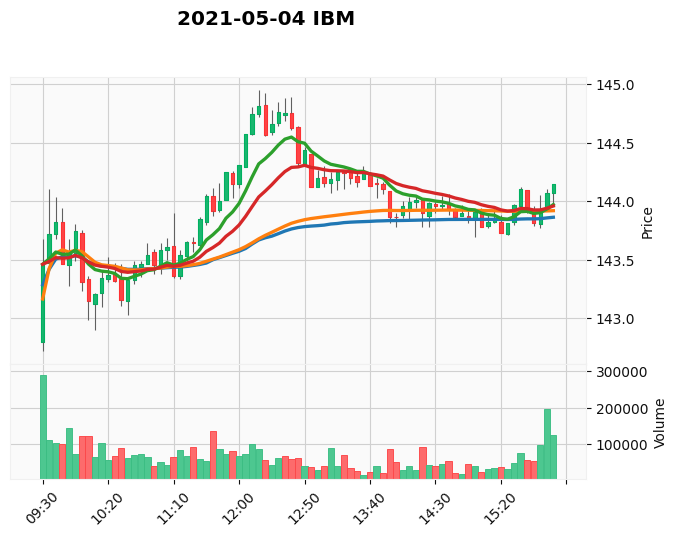

2021-05-04: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.765 IBM shares at 143.4625 per share
09:45:00: Sell 1.765 IBM shares at 143.4625 per share
09:45:00: Open 1.765 IBM short contracts at 143.4625 per contract
09:50:00: Close 1.765 IBM short contracts at 143.5515 per contract
09:50:00: Buy 1.762 IBM shares at 143.5515 per share
10:00:00: Sell 1.762 IBM shares at 143.3142 per share
10:00:00: Open 1.762 IBM short contracts at 143.3142 per contract
10:40:00: Close 1.762 IBM short contracts at 143.4526 per contract
10:40:00: Buy 1.759 IBM shares at 143.4526 per share
11:10:00: Sell 1.759 IBM shares at 143.3637 per share
11:10:00: Open 1.759 IBM short contracts at 143.3637 per contract
11:15:00: Close 1.759 IBM short contracts at 143.5416 per contract
11:15:00: Buy 1.755 IBM shares at 143.5416 per share
15:05:00: Sell 1.755 IBM shares at 143.779 per share
15:05:00: Open 1.755 IBM short contracts at 143.779 per contract
15:15:00: Close 1.755 IBM short contrac

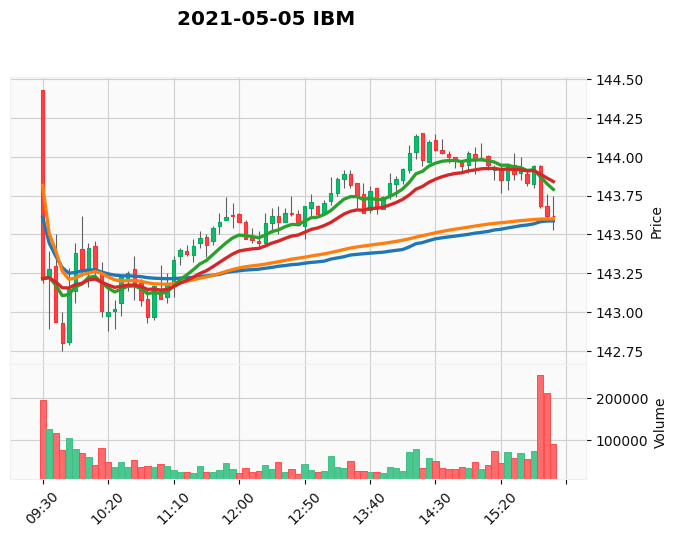

2021-05-05: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.768 IBM short contracts at 143.2153 per contract
09:55:00: Close 1.768 IBM short contracts at 143.3834 per contract
09:55:00: Buy 1.764 IBM shares at 143.3834 per share
10:00:00: Sell 1.764 IBM shares at 143.2648 per share
10:00:00: Open 1.764 IBM short contracts at 143.2648 per contract
10:05:00: Close 1.764 IBM short contracts at 143.4131 per contract
10:05:00: Buy 1.760 IBM shares at 143.4131 per share
10:10:00: Sell 1.760 IBM shares at 143.2648 per share
10:10:00: Open 1.760 IBM short contracts at 143.2648 per contract
10:35:00: Close 1.760 IBM short contracts at 143.2549 per contract
10:35:00: Buy 1.760 IBM shares at 143.2549 per share
10:40:00: Sell 1.760 IBM shares at 143.1758 per share
10:40:00: Open 1.760 IBM short contracts at 143.1758 per contract
11:10:00: Close 1.760 IBM short contracts at 143.334 per contract
11:10:00: Buy 1.756 IBM shares at 143.334 per share
16:00:00: Sell 1.756 IBM s

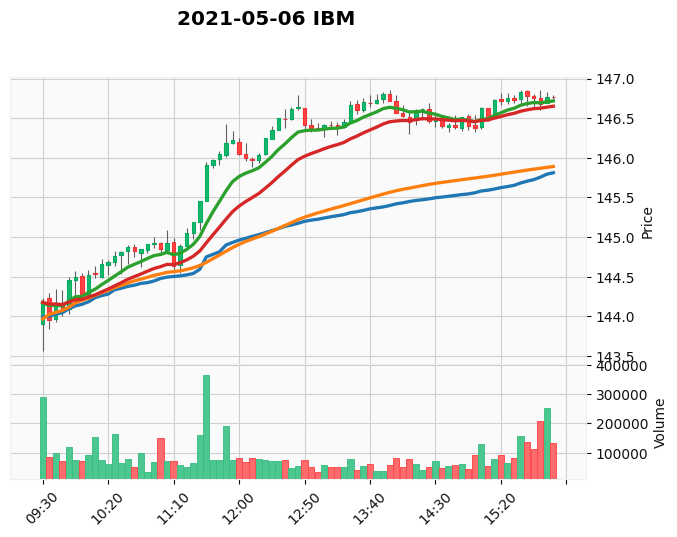

2021-05-06: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.756 IBM shares at 144.1745 per share
09:35:00: Sell 1.756 IBM shares at 143.9551 per share
09:35:00: Open 1.756 IBM short contracts at 143.9551 per contract
09:40:00: Close 1.756 IBM short contracts at 144.1616 per contract
09:40:00: Buy 1.751 IBM shares at 144.1616 per share
16:00:00: Sell 1.751 IBM shares at 146.7653 per share
Cash: 256.97558714273174
Return: 1.51%
Transactions: 6
----------------------------------------------------------------------
2021-05-06: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 1.756 IBM short contracts at 144.1745 per contract
16:00:00: Close 1.756 IBM short contracts at 146.7653 per contract
Cash: 248.61521755611642
Return: -1.80%
Transactions: 2
----------------------------------------------------------------------
2021-05-06: Starting EMA Cross strategy with $253.16455696202533 USD
09:50:00: Buy 1.752 IBM shares at 144.4613 per share
15:00

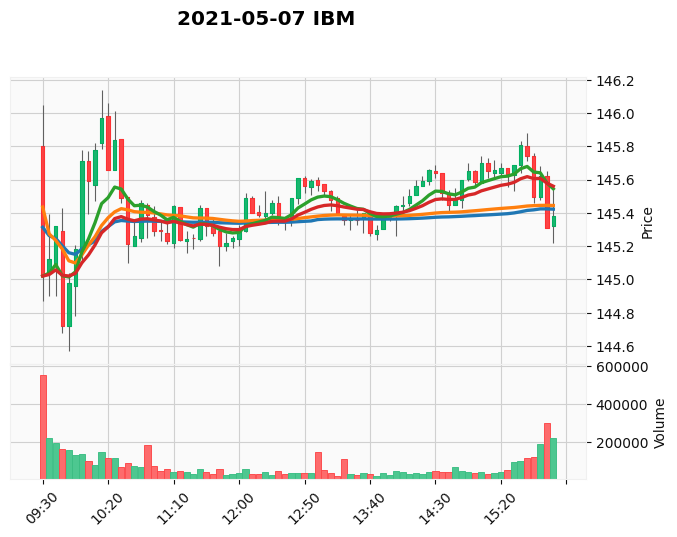

2021-05-07: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.746 IBM short contracts at 145.02 per contract
09:40:00: Close 1.746 IBM short contracts at 145.32 per contract
09:40:00: Buy 1.739 IBM shares at 145.32 per share
09:45:00: Sell 1.739 IBM shares at 144.72 per share
09:45:00: Open 1.739 IBM short contracts at 144.72 per contract
09:55:00: Close 1.739 IBM short contracts at 145.1835 per contract
09:55:00: Buy 1.727 IBM shares at 145.1835 per share
10:35:00: Sell 1.727 IBM shares at 145.215 per share
10:35:00: Open 1.727 IBM short contracts at 145.215 per contract
10:45:00: Close 1.727 IBM short contracts at 145.46 per contract
10:45:00: Buy 1.722 IBM shares at 145.46 per share
10:55:00: Sell 1.722 IBM shares at 145.29 per share
10:55:00: Open 1.722 IBM short contracts at 145.29 per contract
11:10:00: Close 1.722 IBM short contracts at 145.44 per contract
11:10:00: Buy 1.718 IBM shares at 145.44 per share
11:15:00: Sell 1.718 IBM shares at 145.2399 per 

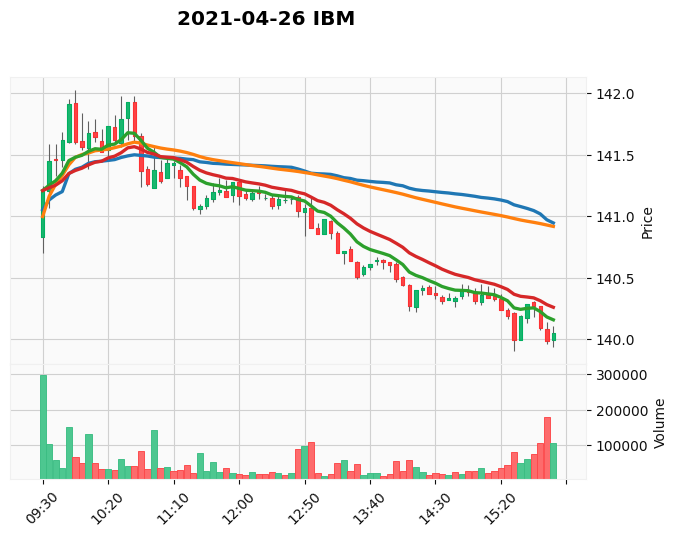

2021-04-26: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.793 IBM shares at 141.2079 per share
10:45:00: Sell 1.793 IBM shares at 141.3662 per share
10:45:00: Open 1.793 IBM short contracts at 141.3662 per contract
16:00:00: Close 1.793 IBM short contracts at 140.051 per contract
Cash: 255.8063211599459
Return: 1.04%
Transactions: 4
----------------------------------------------------------------------
2021-04-26: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 1.793 IBM short contracts at 141.2079 per contract
16:00:00: Close 1.793 IBM short contracts at 140.051 per contract
Cash: 255.23870490947988
Return: 0.82%
Transactions: 2
----------------------------------------------------------------------
2021-04-26: Starting EMA Cross strategy with $253.16455696202533 USD
09:35:00: Buy 1.790 IBM shares at 141.4502 per share
11:00:00: Sell 1.790 IBM shares at 141.287 per share
16:00:00: Sell 0.000 IBM shares at 140.051 per share
Cash: 252.

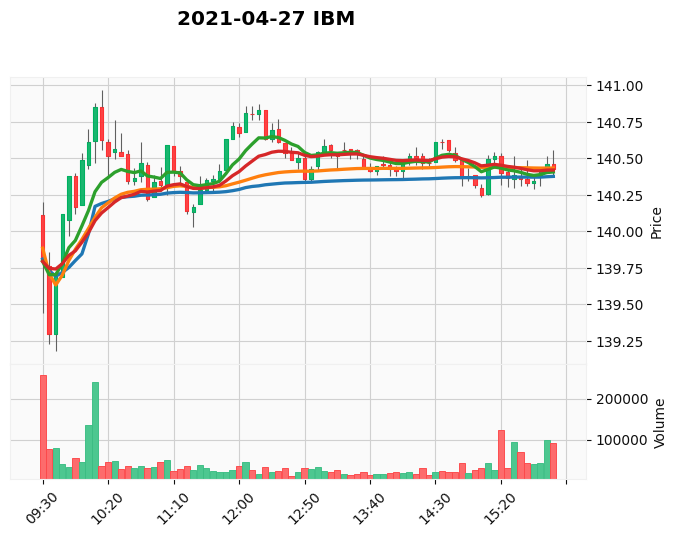

2021-04-27: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.811 IBM short contracts at 139.7939 per contract
09:40:00: Close 1.811 IBM short contracts at 139.7049 per contract
09:40:00: Buy 1.813 IBM shares at 139.7049 per share
10:50:00: Sell 1.813 IBM shares at 140.224 per share
10:50:00: Open 1.813 IBM short contracts at 140.224 per contract
10:55:00: Close 1.813 IBM short contracts at 140.3378 per contract
10:55:00: Buy 1.810 IBM shares at 140.3378 per share
11:20:00: Sell 1.810 IBM shares at 140.14 per share
11:20:00: Open 1.810 IBM short contracts at 140.14 per contract
11:30:00: Close 1.810 IBM short contracts at 140.2814 per contract
11:30:00: Buy 1.807 IBM shares at 140.2814 per share
14:50:00: Sell 1.807 IBM shares at 140.3674 per share
14:50:00: Open 1.807 IBM short contracts at 140.3674 per contract
14:55:00: Close 1.807 IBM short contracts at 140.3773 per contract
14:55:00: Buy 1.806 IBM shares at 140.3773 per share
15:00:00: Sell 1.806 IBM share

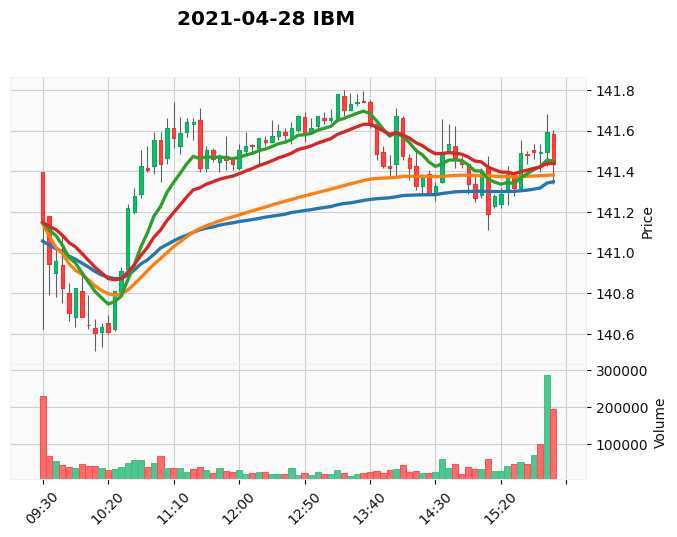

2021-04-28: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 1.794 IBM shares at 141.1486 per share
09:35:00: Sell 1.794 IBM shares at 140.9458 per share
09:35:00: Open 1.794 IBM short contracts at 140.9458 per contract
10:30:00: Close 1.794 IBM short contracts at 140.9113 per contract
10:30:00: Buy 1.794 IBM shares at 140.9113 per share
15:00:00: Sell 1.794 IBM shares at 141.2673 per share
15:00:00: Open 1.794 IBM short contracts at 141.2673 per contract
15:05:00: Close 1.794 IBM short contracts at 141.3997 per contract
15:05:00: Buy 1.791 IBM shares at 141.3997 per share
15:10:00: Sell 1.791 IBM shares at 141.1882 per share
15:10:00: Open 1.791 IBM short contracts at 141.1882 per contract
15:25:00: Close 1.791 IBM short contracts at 141.3853 per contract
15:25:00: Buy 1.786 IBM shares at 141.3853 per share
16:00:00: Sell 1.786 IBM shares at 141.4354 per share
Cash: 252.62157260252525
Return: -0.21%
Transactions: 14
----------------------------------------------

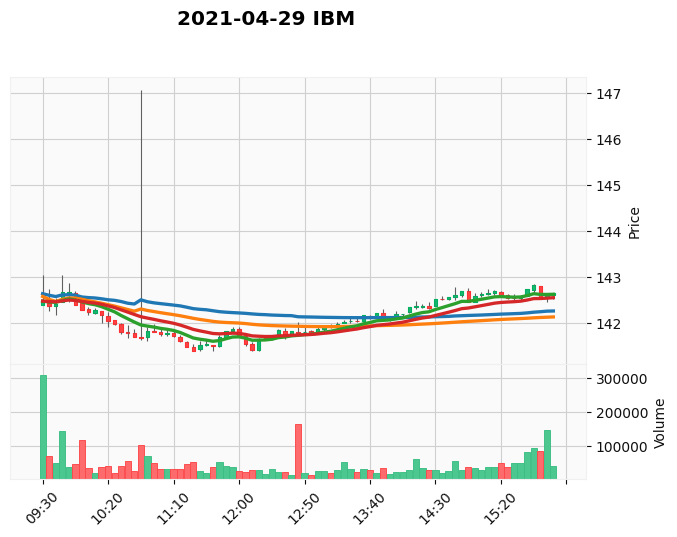

2021-04-29: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.777 IBM short contracts at 142.4737 per contract
09:45:00: Close 1.777 IBM short contracts at 142.6616 per contract
09:45:00: Buy 1.772 IBM shares at 142.6616 per share
09:55:00: Sell 1.772 IBM shares at 142.3946 per share
09:55:00: Open 1.772 IBM short contracts at 142.3946 per contract
13:35:00: Close 1.772 IBM short contracts at 142.177 per contract
13:35:00: Buy 1.778 IBM shares at 142.177 per share
13:50:00: Sell 1.778 IBM shares at 142.0979 per share
13:50:00: Open 1.778 IBM short contracts at 142.0979 per contract
14:00:00: Close 1.778 IBM short contracts at 142.1869 per contract
14:00:00: Buy 1.775 IBM shares at 142.1869 per share
16:00:00: Sell 1.775 IBM shares at 142.6418 per share
Cash: 253.25194683901495
Return: 0.03%
Transactions: 12
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 1

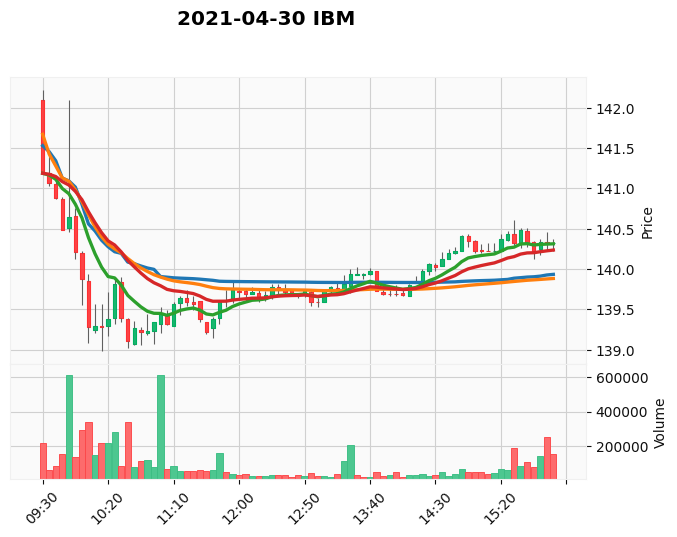

2021-04-30: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 1.793 IBM short contracts at 141.1882 per contract
13:25:00: Close 1.793 IBM short contracts at 139.9442 per contract
13:25:00: Buy 1.825 IBM shares at 139.9442 per share
13:45:00: Sell 1.825 IBM shares at 139.7247 per share
13:45:00: Open 1.825 IBM short contracts at 139.7247 per contract
14:20:00: Close 1.825 IBM short contracts at 139.9818 per contract
14:20:00: Buy 1.818 IBM shares at 139.9818 per share
16:00:00: Sell 1.818 IBM shares at 140.3279 per share
Cash: 255.15469344214227
Return: 0.79%
Transactions: 8
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 1.793 IBM shares at 141.1882 per share
16:00:00: Sell 1.793 IBM shares at 140.3279 per share
Cash: 251.62195305918905
Return: -0.61%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting

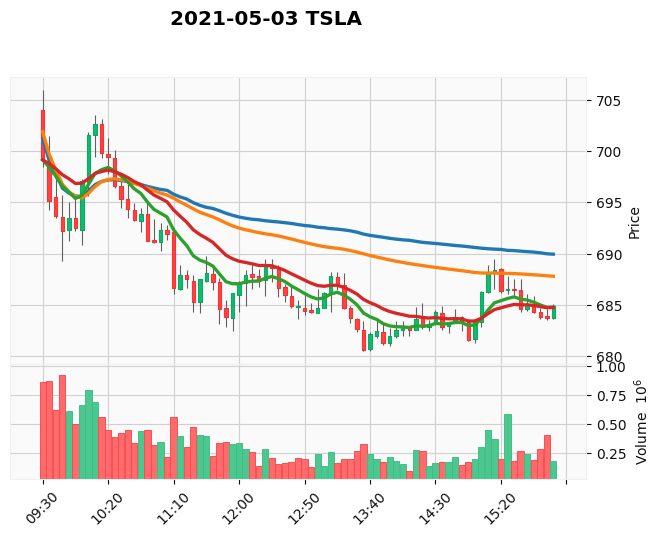

2021-05-03: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.362 TSLA short contracts at 699.16 per contract
10:00:00: Close 0.362 TSLA short contracts at 697.05 per contract
10:00:00: Buy 0.364 TSLA shares at 697.05 per share
10:25:00: Sell 0.364 TSLA shares at 696.58 per share
10:25:00: Open 0.364 TSLA short contracts at 696.58 per contract
16:00:00: Close 0.364 TSLA short contracts at 684.8748 per contract
Cash: 258.0214589719635
Return: 1.92%
Transactions: 6
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 0.362 TSLA shares at 699.16 per share
16:00:00: Sell 0.362 TSLA shares at 684.8748 per share
Cash: 247.99191217526135
Return: -2.04%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $253.16455696202533 USD
10:10:00: Buy 0.360 TSLA shares at 702.64 per share
10:30:00: S

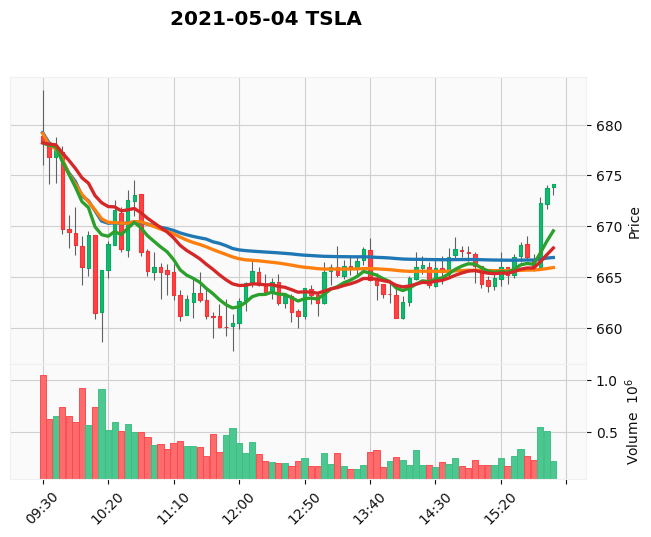

2021-05-04: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.373 TSLA short contracts at 678.21 per contract
10:25:00: Close 0.373 TSLA short contracts at 671.5937 per contract
10:25:00: Buy 0.381 TSLA shares at 671.5937 per share
10:30:00: Sell 0.381 TSLA shares at 667.75 per share
10:30:00: Open 0.381 TSLA short contracts at 667.75 per contract
10:35:00: Close 0.381 TSLA short contracts at 672.6 per contract
10:35:00: Buy 0.375 TSLA shares at 672.6 per share
10:45:00: Sell 0.375 TSLA shares at 667.4315 per share
10:45:00: Open 0.375 TSLA short contracts at 667.4315 per contract
13:35:00: Close 0.375 TSLA short contracts at 667.78 per contract
13:35:00: Buy 0.375 TSLA shares at 667.78 per share
13:40:00: Sell 0.375 TSLA shares at 664.74 per share
13:40:00: Open 0.375 TSLA short contracts at 664.74 per contract
14:40:00: Close 0.375 TSLA short contracts at 667.01 per contract
14:40:00: Buy 0.372 TSLA shares at 667.01 per share
15:00:00: Sell 0.372 TSLA shares 

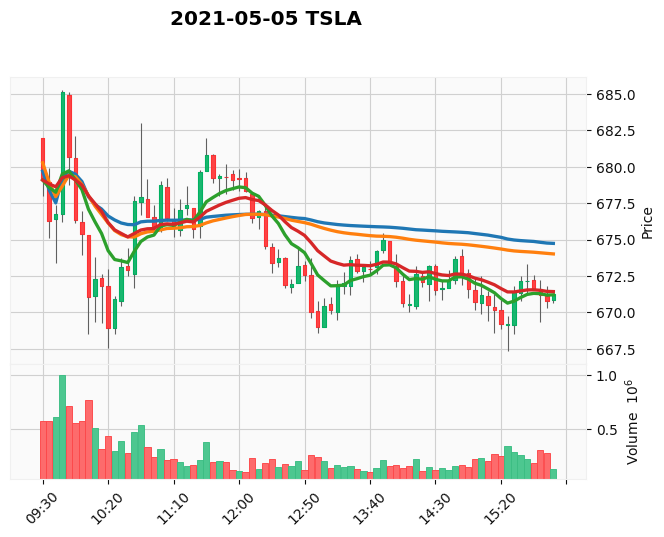

2021-05-05: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.373 TSLA short contracts at 679.0862 per contract
09:45:00: Close 0.373 TSLA short contracts at 685.135 per contract
09:45:00: Buy 0.366 TSLA shares at 685.135 per share
09:55:00: Sell 0.366 TSLA shares at 676.34 per share
09:55:00: Open 0.366 TSLA short contracts at 676.34 per contract
10:40:00: Close 0.366 TSLA short contracts at 677.6734 per contract
10:40:00: Buy 0.365 TSLA shares at 677.6734 per share
10:55:00: Sell 0.365 TSLA shares at 675.9008 per share
10:55:00: Open 0.365 TSLA short contracts at 675.9008 per contract
11:00:00: Close 0.365 TSLA short contracts at 678.715 per contract
11:00:00: Buy 0.362 TSLA shares at 678.715 per share
11:10:00: Sell 0.362 TSLA shares at 675.77 per share
11:10:00: Open 0.362 TSLA short contracts at 675.77 per contract
11:15:00: Close 0.362 TSLA short contracts at 677.03 per contract
11:15:00: Buy 0.360 TSLA shares at 677.03 per share
11:25:00: Sell 0.360 TSLA

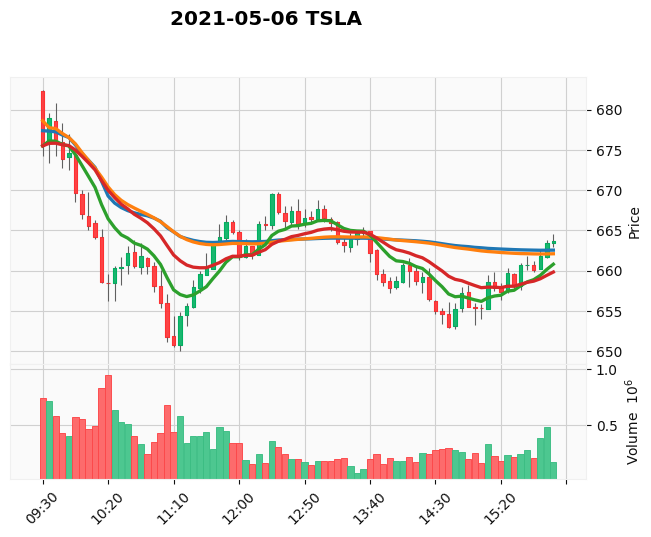

2021-05-06: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.375 TSLA short contracts at 675.48 per contract
09:35:00: Close 0.375 TSLA short contracts at 678.8899 per contract
09:35:00: Buy 0.371 TSLA shares at 678.8899 per share
09:40:00: Sell 0.371 TSLA shares at 675.9328 per share
09:40:00: Open 0.371 TSLA short contracts at 675.9328 per contract
11:40:00: Close 0.371 TSLA short contracts at 663.522 per contract
11:40:00: Buy 0.385 TSLA shares at 663.522 per share
12:00:00: Sell 0.385 TSLA shares at 661.7073 per share
12:00:00: Open 0.385 TSLA short contracts at 661.7073 per contract
12:15:00: Close 0.385 TSLA short contracts at 665.834 per contract
12:15:00: Buy 0.380 TSLA shares at 665.834 per share
13:15:00: Sell 0.380 TSLA shares at 663.54 per share
13:15:00: Open 0.380 TSLA short contracts at 663.54 per contract
13:30:00: Close 0.380 TSLA short contracts at 664.603 per contract
13:30:00: Buy 0.379 TSLA shares at 664.603 per share
13:40:00: Sell 0.379 

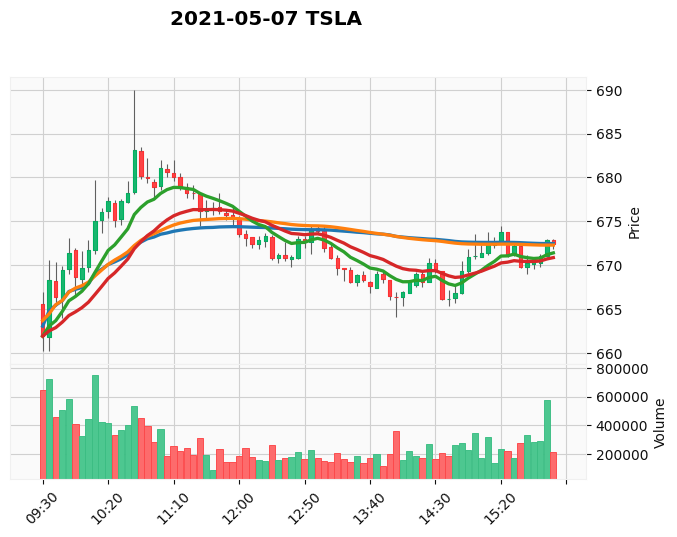

2021-05-07: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.382 TSLA short contracts at 661.9052 per contract
09:35:00: Close 0.382 TSLA short contracts at 668.3499 per contract
09:35:00: Buy 0.375 TSLA shares at 668.3499 per share
12:00:00: Sell 0.375 TSLA shares at 673.5617 per share
12:00:00: Open 0.375 TSLA short contracts at 673.5617 per contract
12:55:00: Close 0.375 TSLA short contracts at 674.152 per contract
12:55:00: Buy 0.374 TSLA shares at 674.152 per share
13:00:00: Sell 0.374 TSLA shares at 673.88 per share
13:00:00: Open 0.374 TSLA short contracts at 673.88 per contract
15:20:00: Close 0.374 TSLA short contracts at 673.76 per contract
15:20:00: Buy 0.375 TSLA shares at 673.76 per share
15:25:00: Sell 0.375 TSLA shares at 671.1658 per share
15:25:00: Open 0.375 TSLA short contracts at 671.1658 per contract
15:55:00: Close 0.375 TSLA short contracts at 672.9 per contract
15:55:00: Buy 0.373 TSLA shares at 672.9 per share
16:00:00: Sell 0.373 TSLA

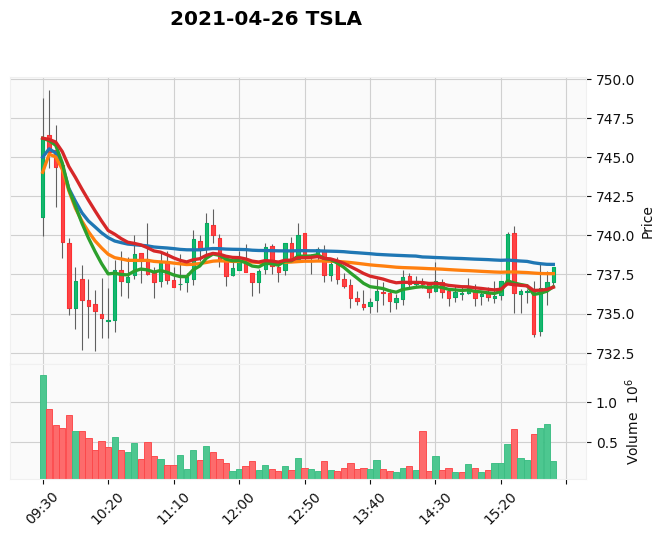

2021-04-26: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 0.339 TSLA shares at 746.2 per share
09:35:00: Sell 0.339 TSLA shares at 745.3469 per share
09:35:00: Open 0.339 TSLA short contracts at 745.3469 per contract
11:25:00: Close 0.339 TSLA short contracts at 739.77 per contract
11:25:00: Buy 0.344 TSLA shares at 739.77 per share
11:45:00: Sell 0.344 TSLA shares at 738.34 per share
11:45:00: Open 0.344 TSLA short contracts at 738.34 per contract
12:20:00: Close 0.344 TSLA short contracts at 739.2477 per contract
12:20:00: Buy 0.344 TSLA shares at 739.2477 per share
12:25:00: Sell 0.344 TSLA shares at 738.065 per share
12:25:00: Open 0.344 TSLA short contracts at 738.065 per contract
12:35:00: Close 0.344 TSLA short contracts at 739.52 per contract
12:35:00: Buy 0.342 TSLA shares at 739.52 per share
12:40:00: Sell 0.342 TSLA shares at 738.4506 per share
12:40:00: Open 0.342 TSLA short contracts at 738.4506 per contract
12:45:00: Close 0.342 TSLA short contra

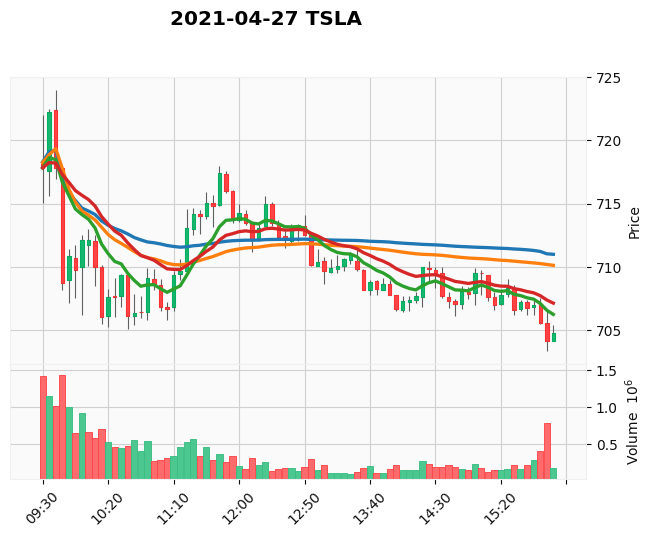

2021-04-27: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.353 TSLA short contracts at 717.82 per contract
09:35:00: Close 0.353 TSLA short contracts at 722.21 per contract
09:35:00: Buy 0.348 TSLA shares at 722.21 per share
09:40:00: Sell 0.348 TSLA shares at 717.8199 per share
09:40:00: Open 0.348 TSLA short contracts at 717.8199 per contract
11:20:00: Close 0.348 TSLA short contracts at 713.1 per contract
11:20:00: Buy 0.353 TSLA shares at 713.1 per share
12:35:00: Sell 0.353 TSLA shares at 712.0981 per share
12:35:00: Open 0.353 TSLA short contracts at 712.0981 per contract
12:40:00: Close 0.353 TSLA short contracts at 713.1047 per contract
12:40:00: Buy 0.352 TSLA shares at 713.1047 per share
12:55:00: Sell 0.352 TSLA shares at 710.18 per share
12:55:00: Open 0.352 TSLA short contracts at 710.18 per contract
16:00:00: Close 0.352 TSLA short contracts at 704.74 per contract
Cash: 251.90756861050295
Return: -0.50%
Transactions: 14
------------------------

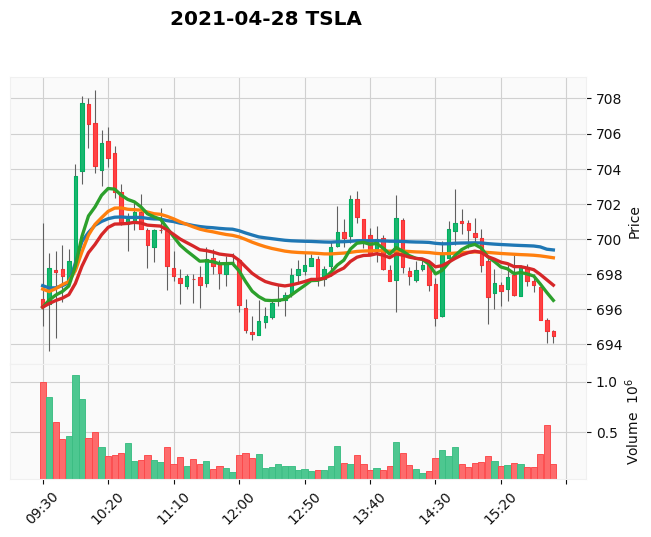

2021-04-28: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.364 TSLA short contracts at 696.0974 per contract
09:35:00: Close 0.364 TSLA short contracts at 698.31 per contract
09:35:00: Buy 0.361 TSLA shares at 698.31 per share
10:30:00: Sell 0.361 TSLA shares at 700.945 per share
10:30:00: Open 0.361 TSLA short contracts at 700.945 per contract
10:40:00: Close 0.361 TSLA short contracts at 701.4975 per contract
10:40:00: Buy 0.361 TSLA shares at 701.4975 per share
10:45:00: Sell 0.361 TSLA shares at 700.549 per share
10:45:00: Open 0.361 TSLA short contracts at 700.549 per contract
13:15:00: Close 0.361 TSLA short contracts at 700.4 per contract
13:15:00: Buy 0.361 TSLA shares at 700.4 per share
13:40:00: Sell 0.361 TSLA shares at 699.1961 per share
13:40:00: Open 0.361 TSLA short contracts at 699.1961 per contract
13:45:00: Close 0.361 TSLA short contracts at 699.96 per contract
13:45:00: Buy 0.360 TSLA shares at 699.96 per share
13:50:00: Sell 0.360 TSLA s

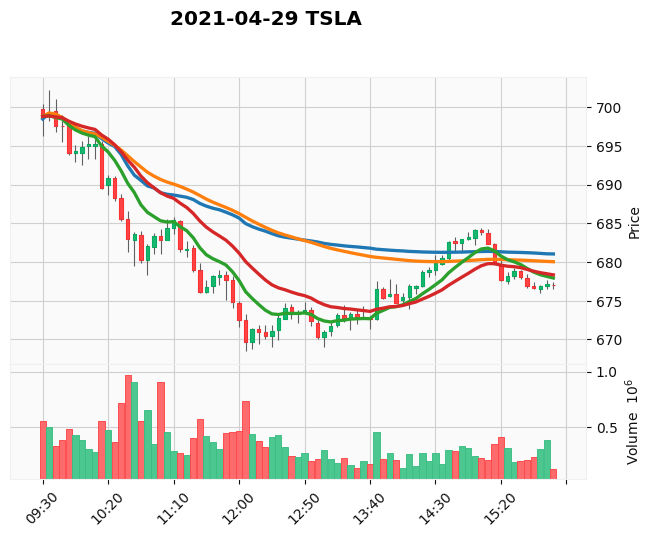

2021-04-29: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 0.362 TSLA shares at 698.8046 per share
09:40:00: Sell 0.362 TSLA shares at 697.6 per share
09:40:00: Open 0.362 TSLA short contracts at 697.6 per contract
14:40:00: Close 0.362 TSLA short contracts at 682.64 per contract
14:40:00: Buy 0.378 TSLA shares at 682.64 per share
15:15:00: Sell 0.378 TSLA shares at 679.8456 per share
15:15:00: Open 0.378 TSLA short contracts at 679.8456 per contract
16:00:00: Close 0.378 TSLA short contracts at 677.0 per contract
Cash: 258.16725713831215
Return: 1.98%
Transactions: 8
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 0.362 TSLA short contracts at 698.8046 per contract
10:30:00: Close 0.362 TSLA short contracts at 685.5576 per contract
10:30:00: Buy 0.376 TSLA shares at 685.5576 per share
16:00:00: Sell 0.376 TSLA shares at 677.0 per share
Cash: 254.74363104

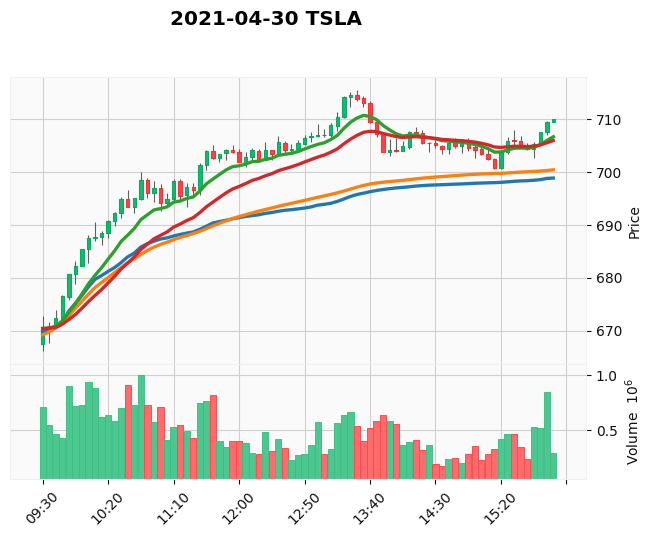

2021-04-30: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 0.378 TSLA shares at 670.39 per share
16:00:00: Sell 0.378 TSLA shares at 709.84 per share
Cash: 268.06236536034856
Return: 5.88%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 0.378 TSLA short contracts at 670.39 per contract
16:00:00: Close 0.378 TSLA short contracts at 709.84 per contract
Cash: 238.2667485637021
Return: -5.88%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $253.16455696202533 USD
09:35:00: Buy 0.377 TSLA shares at 670.9178 per share
14:30:00: Sell 0.377 TSLA shares at 705.09 per share
15:50:00: Buy 0.376 TSLA shares at 707.43 per share
16:00:00: Sell 0.376 TSLA shares at 709.84 per share
Cash: 266.96549995512896
Return: 5.45%
Transactions: 4
------------------------------------

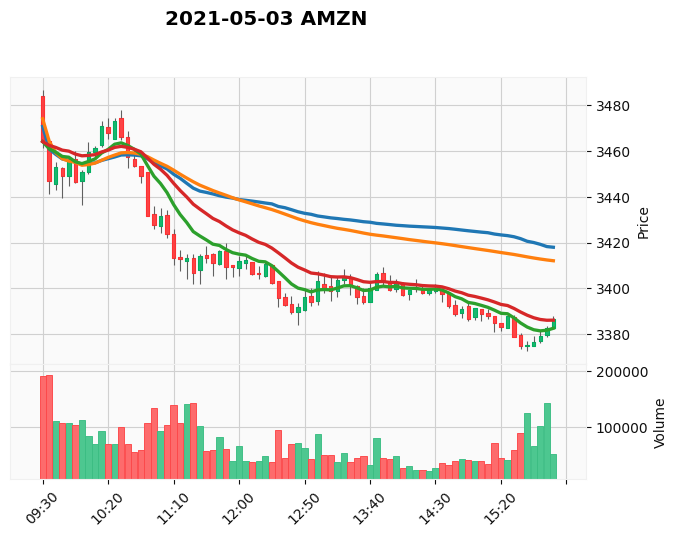

2021-05-03: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.073 AMZN short contracts at 3464.01 per contract
10:05:00: Close 0.073 AMZN short contracts at 3459.555 per contract
10:05:00: Buy 0.073 AMZN shares at 3459.555 per share
10:35:00: Sell 0.073 AMZN shares at 3457.13 per share
10:35:00: Open 0.073 AMZN short contracts at 3457.13 per contract
16:00:00: Close 0.073 AMZN short contracts at 3386.49 per contract
Cash: 258.4884289608253
Return: 2.10%
Transactions: 6
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 0.073 AMZN shares at 3464.01 per share
16:00:00: Sell 0.073 AMZN shares at 3386.49 per share
Cash: 247.4990662574095
Return: -2.24%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $253.16455696202533 USD
10:20:00: Buy 0.073 AMZN shares at 3467.8 per share
10:40:

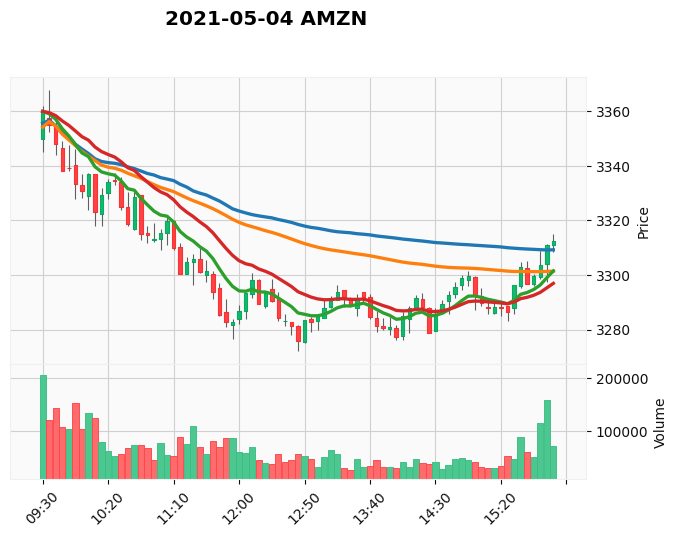

2021-05-04: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 0.075 AMZN shares at 3360.0 per share
09:35:00: Sell 0.075 AMZN shares at 3355.15 per share
09:35:00: Open 0.075 AMZN short contracts at 3355.15 per contract
15:55:00: Close 0.075 AMZN short contracts at 3310.98 per contract
15:55:00: Buy 0.077 AMZN shares at 3310.98 per share
16:00:00: Sell 0.077 AMZN shares at 3312.65 per share
Cash: 256.2563710925393
Return: 1.22%
Transactions: 6
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 0.075 AMZN short contracts at 3360.0 per contract
11:40:00: Close 0.075 AMZN short contracts at 3293.7056 per contract
11:40:00: Buy 0.078 AMZN shares at 3293.7056 per share
16:00:00: Sell 0.078 AMZN shares at 3312.65 per share
Cash: 259.6444703691472
Return: 2.56%
Transactions: 4
----------------------------------------------------------------------
2021-05-04: Starting 

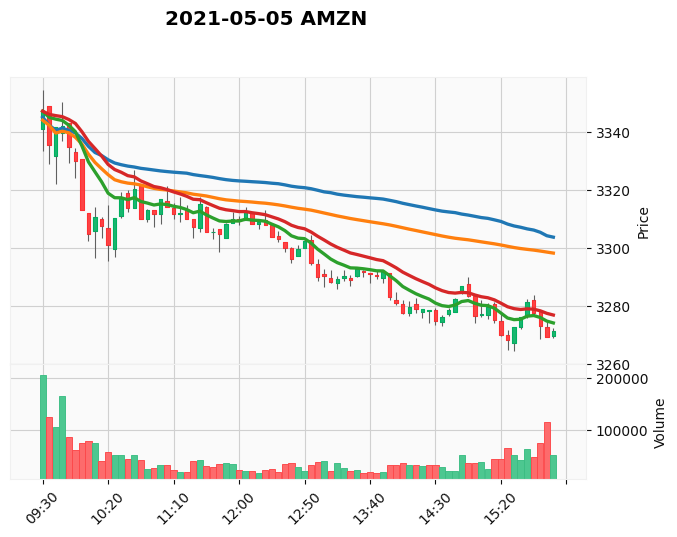

2021-05-05: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 0.076 AMZN shares at 3347.27 per share
09:35:00: Sell 0.076 AMZN shares at 3335.5 per share
09:35:00: Open 0.076 AMZN short contracts at 3335.5 per contract
09:40:00: Close 0.076 AMZN short contracts at 3341.678 per contract
09:40:00: Buy 0.075 AMZN shares at 3341.678 per share
09:50:00: Sell 0.075 AMZN shares at 3334.98 per share
09:50:00: Open 0.075 AMZN short contracts at 3334.98 per contract
16:00:00: Close 0.075 AMZN short contracts at 3271.17 per contract
Cash: 256.11068168733334
Return: 1.16%
Transactions: 8
----------------------------------------------------------------------
2021-05-05: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Open 0.076 AMZN short contracts at 3347.27 per contract
13:55:00: Close 0.076 AMZN short contracts at 3283.0 per contract
13:55:00: Buy 0.079 AMZN shares at 3283.0 per share
16:00:00: Sell 0.079 AMZN shares at 3271.17 per share
Cash: 257.095727

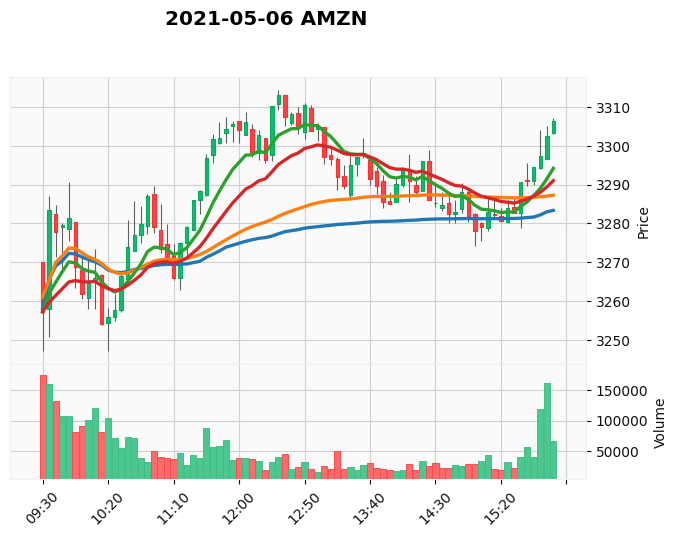

2021-05-06: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.078 AMZN short contracts at 3257.27 per contract
09:35:00: Close 0.078 AMZN short contracts at 3283.45 per contract
09:35:00: Buy 0.076 AMZN shares at 3283.45 per share
09:55:00: Sell 0.076 AMZN shares at 3268.704 per share
09:55:00: Open 0.076 AMZN short contracts at 3268.704 per contract
10:35:00: Close 0.076 AMZN short contracts at 3273.94 per contract
10:35:00: Buy 0.076 AMZN shares at 3273.94 per share
11:10:00: Sell 0.076 AMZN shares at 3265.86 per share
11:10:00: Open 0.076 AMZN short contracts at 3265.86 per contract
11:15:00: Close 0.076 AMZN short contracts at 3274.965 per contract
11:15:00: Buy 0.076 AMZN shares at 3274.965 per share
15:00:00: Sell 0.076 AMZN shares at 3278.0227 per share
15:00:00: Open 0.076 AMZN short contracts at 3278.0227 per contract
15:10:00: Close 0.076 AMZN short contracts at 3282.88 per contract
15:10:00: Buy 0.076 AMZN shares at 3282.88 per share
15:20:00: Sell 0

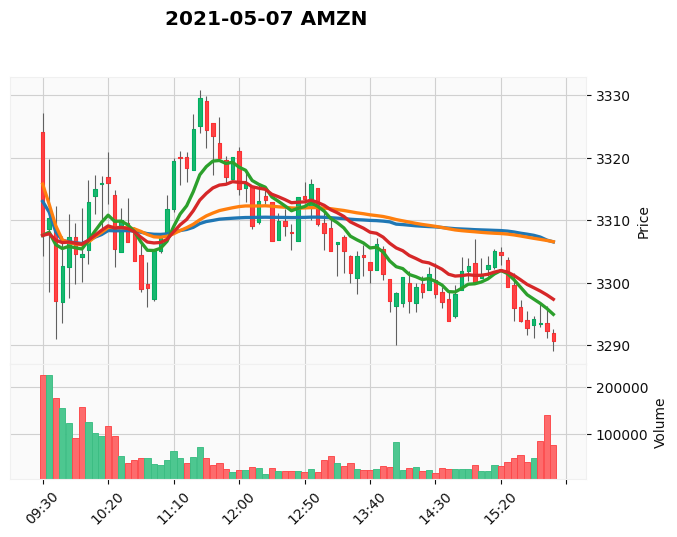

2021-05-07: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.077 AMZN short contracts at 3307.56 per contract
09:50:00: Close 0.077 AMZN short contracts at 3307.38 per contract
09:50:00: Buy 0.077 AMZN shares at 3307.38 per share
09:55:00: Sell 0.077 AMZN shares at 3304.55 per share
09:55:00: Open 0.077 AMZN short contracts at 3304.55 per contract
10:05:00: Close 0.077 AMZN short contracts at 3312.995 per contract
10:05:00: Buy 0.076 AMZN shares at 3312.995 per share
10:25:00: Sell 0.076 AMZN shares at 3305.42 per share
10:25:00: Open 0.076 AMZN short contracts at 3305.42 per contract
10:30:00: Close 0.076 AMZN short contracts at 3310.0 per contract
10:30:00: Buy 0.076 AMZN shares at 3310.0 per share
10:35:00: Sell 0.076 AMZN shares at 3306.57 per share
10:35:00: Open 0.076 AMZN short contracts at 3306.57 per contract
11:05:00: Close 0.076 AMZN short contracts at 3311.735 per contract
11:05:00: Buy 0.076 AMZN shares at 3311.735 per share
12:10:00: Sell 0.076 A

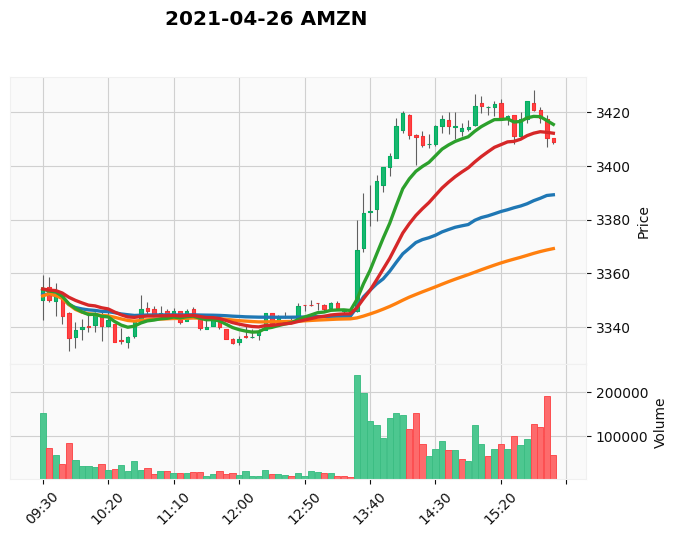

2021-04-26: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 0.075 AMZN shares at 3354.085 per share
09:35:00: Sell 0.075 AMZN shares at 3349.8355 per share
09:35:00: Open 0.075 AMZN short contracts at 3349.8355 per contract
10:45:00: Close 0.075 AMZN short contracts at 3346.7419 per contract
10:45:00: Buy 0.076 AMZN shares at 3346.7419 per share
10:55:00: Sell 0.076 AMZN shares at 3343.85 per share
10:55:00: Open 0.076 AMZN short contracts at 3343.85 per contract
11:00:00: Close 0.076 AMZN short contracts at 3345.07 per contract
11:00:00: Buy 0.076 AMZN shares at 3345.07 per share
11:05:00: Sell 0.076 AMZN shares at 3344.02 per share
11:05:00: Open 0.076 AMZN short contracts at 3344.02 per contract
11:10:00: Close 0.076 AMZN short contracts at 3345.8 per contract
11:10:00: Buy 0.075 AMZN shares at 3345.8 per share
11:15:00: Sell 0.075 AMZN shares at 3341.72 per share
11:15:00: Open 0.075 AMZN short contracts at 3341.72 per contract
11:20:00: Close 0.075 AMZN sho

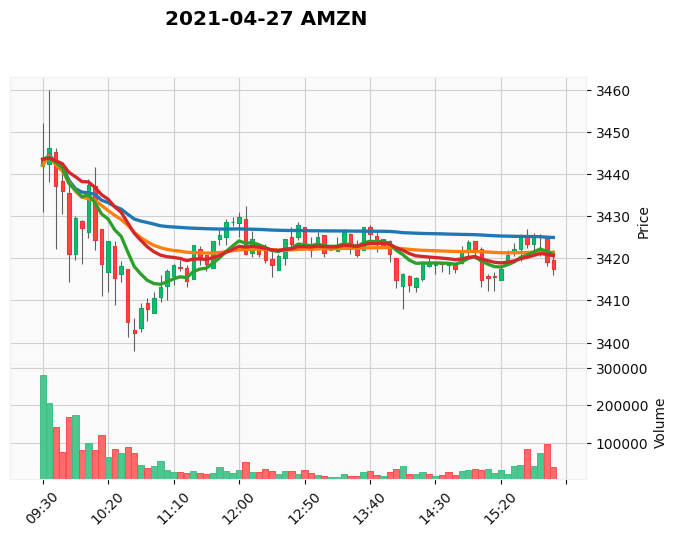

2021-04-27: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 0.074 AMZN shares at 3443.51 per share
09:40:00: Sell 0.074 AMZN shares at 3437.18 per share
09:40:00: Open 0.074 AMZN short contracts at 3437.18 per contract
10:05:00: Close 0.074 AMZN short contracts at 3437.415 per contract
10:05:00: Buy 0.074 AMZN shares at 3437.415 per share
10:10:00: Sell 0.074 AMZN shares at 3424.3254 per share
10:10:00: Open 0.074 AMZN short contracts at 3424.3254 per contract
11:50:00: Close 0.074 AMZN short contracts at 3428.5 per contract
11:50:00: Buy 0.073 AMZN shares at 3428.5 per share
12:05:00: Sell 0.073 AMZN shares at 3420.9443 per share
12:05:00: Open 0.073 AMZN short contracts at 3420.9443 per contract
12:45:00: Close 0.073 AMZN short contracts at 3427.94 per contract
12:45:00: Buy 0.073 AMZN shares at 3427.94 per share
12:50:00: Sell 0.073 AMZN shares at 3422.5 per share
12:50:00: Open 0.073 AMZN short contracts at 3422.5 per contract
13:35:00: Close 0.073 AMZN shor

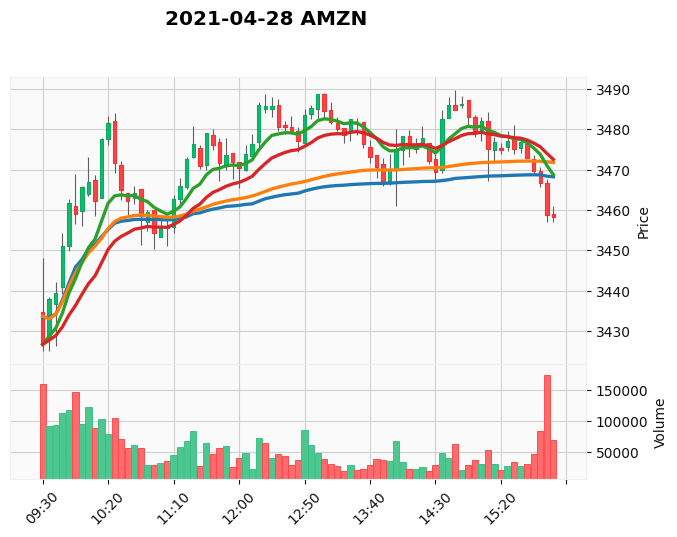

2021-04-28: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.074 AMZN short contracts at 3426.6201 per contract
09:35:00: Close 0.074 AMZN short contracts at 3438.015 per contract
09:35:00: Buy 0.073 AMZN shares at 3438.015 per share
10:55:00: Sell 0.073 AMZN shares at 3454.225 per share
10:55:00: Open 0.073 AMZN short contracts at 3454.225 per contract
11:10:00: Close 0.073 AMZN short contracts at 3462.7761 per contract
11:10:00: Buy 0.073 AMZN shares at 3462.7761 per share
15:50:00: Sell 0.073 AMZN shares at 3466.785 per share
15:50:00: Open 0.073 AMZN short contracts at 3466.785 per contract
16:00:00: Close 0.073 AMZN short contracts at 3458.28 per contract
Cash: 253.79866775954076
Return: 0.25%
Transactions: 10
----------------------------------------------------------------------
2021-04-28: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 0.074 AMZN shares at 3426.6201 per share
16:00:00: Sell 0.074 AMZN shares at 3458.28 per share

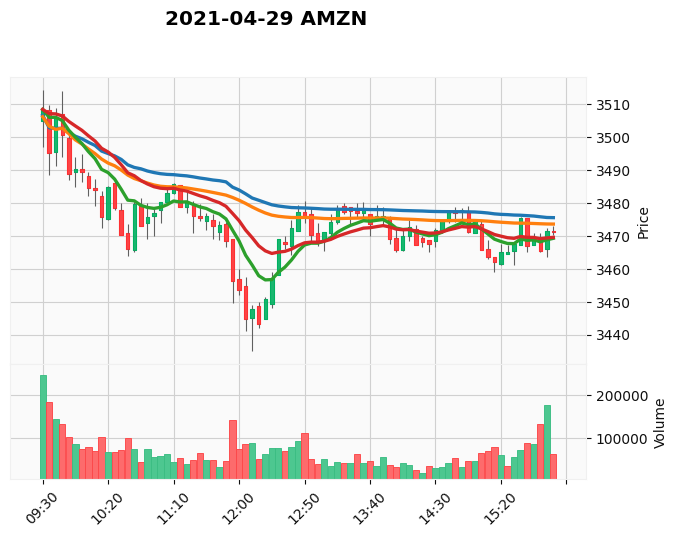

2021-04-29: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Buy 0.072 AMZN shares at 3508.44 per share
09:35:00: Sell 0.072 AMZN shares at 3495.15 per share
09:35:00: Open 0.072 AMZN short contracts at 3495.15 per contract
09:40:00: Close 0.072 AMZN short contracts at 3506.13 per contract
09:40:00: Buy 0.072 AMZN shares at 3506.13 per share
09:45:00: Sell 0.072 AMZN shares at 3500.58 per share
09:45:00: Open 0.072 AMZN short contracts at 3500.58 per contract
13:15:00: Close 0.072 AMZN short contracts at 3478.425 per contract
13:15:00: Buy 0.073 AMZN shares at 3478.425 per share
13:20:00: Sell 0.073 AMZN shares at 3477.3425 per share
13:20:00: Open 0.073 AMZN short contracts at 3477.3425 per contract
14:50:00: Close 0.073 AMZN short contracts at 3477.9499 per contract
14:50:00: Buy 0.073 AMZN shares at 3477.9499 per share
14:55:00: Sell 0.073 AMZN shares at 3471.04 per share
14:55:00: Open 0.073 AMZN short contracts at 3471.04 per contract
16:00:00: Close 0.073 AMZN 

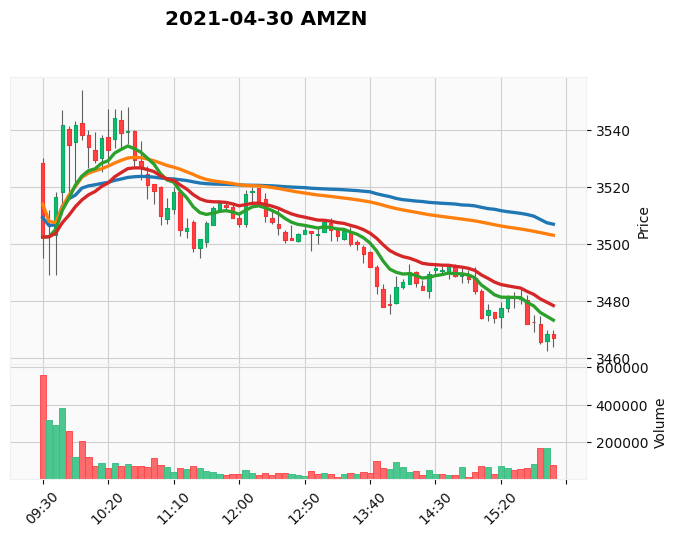

2021-04-30: Starting VWAP Cross strategy with $253.16455696202533 USD
09:30:00: Open 0.072 AMZN short contracts at 3502.39 per contract
09:40:00: Close 0.072 AMZN short contracts at 3516.43 per contract
09:40:00: Buy 0.072 AMZN shares at 3516.43 per share
10:50:00: Sell 0.072 AMZN shares at 3520.5187 per share
10:50:00: Open 0.072 AMZN short contracts at 3520.5187 per contract
16:00:00: Close 0.072 AMZN short contracts at 3467.2 per contract
Cash: 256.2661627394748
Return: 1.23%
Transactions: 6
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $253.16455696202533 USD
09:30:00: Buy 0.072 AMZN shares at 3502.39 per share
16:00:00: Sell 0.072 AMZN shares at 3467.2 per share
Cash: 250.62090512442478
Return: -1.00%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $253.16455696202533 USD
09:35:00: Buy 0.072 AMZN shares at 3503.29 per share
11:0

In [15]:
if __name__ == '__main__': 
    portfolio = ['AAPL','GME','IBM','TSLA','AMZN'] 
    cash = 100000 
    show_transactions = True 
    show_graphs       = True 
    main(portfolio,cash,show_transactions,show_graphs)